# Analysis of Pedestrian Dynamics in Bottleneck Scenarios using PedPy and Reinforcement Learning

This notebook explores the behavior of **pedestrian traffic** in **bottleneck** situations, using simulations trained via **reinforcement learning**. By employing the **PedPy** library, we visualize and analyze trajectories, density, and velocity of pedestrians as they navigate through constrained environments. The objective is to enhance our understanding of pedestrian flow dynamics under stress conditions and to contribute to the development of effective crowd management strategies in bottleneck scenarios.

## Key Studies Utilized

To study in deep our analysis, we have selected specific aspects from two studies on pedestrian dynamics in bottleneck scenarios.

### 1. [**Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology**](https://royalsocietypublishing.org/doi/10.1098/rsif.2019.0871)

This study examines how various factors influence crowd dynamics at bottleneck entrances. For the purpose of our analysis, we specifically focused on how the corridor width at the entrance affects the pedestrian flow and density. The findings from the study indicate that the density of persons per square meter increases with corridor width, which informs our simulations of pedestrian traffic at different entrance widths in bottleneck scenarios.

### 2. [**Pedestrian flow through multiple bottlenecks**](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.86.026118)

Focusing on the section "Merging" from this study, we explore the paradoxical effects of architectural designs on pedestrian flow. The study compares two types of connections—center and corner—and reveals that while corner connections improve local evacuation times, they paradoxically increase the total evacuation time due to higher inflow rates leading to increased density near the exits. This phenomenon highlights the complexity of optimizing pedestrian flow in systems with multiple bottlenecks, which is crucial for our analysis of similar scenarios.


## Environment Setup and Library Imports

In this section, we set up our Python environment by importing necessary libraries and configuring the plotting settings. This includes importing data handling libraries like `pandas`, geometric operations library `shapely`, and visualization libraries such as `matplotlib`. We also import the `pedpy` library, which provides tools specifically designed for analyzing pedestrian dynamics, including functions for computing density, speed, and flow of pedestrian traffic, as well as visualizing these metrics.

In [101]:
%matplotlib inline

import re
import os
import pedpy
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
from shapely import Polygon
from typing import Collection

from pedpy.column_identifier import DENSITY_COL
from matplotlib.animation import FuncAnimation

from pedpy import (

    compute_speed_profile, SpeedMethod,
    get_grid_cells, compute_grid_cell_polygon_intersection_area,
    compute_individual_voronoi_polygons, compute_individual_speed,
    SpeedCalculation, Cutoff, plot_profiles,
    TrajectoryData, WalkableArea, plot_measurement_setup,
    compute_classic_density, MeasurementArea, compute_voronoi_density,
    plot_voronoi_cells, MeasurementLine, compute_density_profile, DensityMethod,
    plot_nt, compute_n_t, plot_density_distribution, compute_passing_density,
    compute_frame_range_in_area, plot_time_distance, compute_time_distance_line,
    compute_flow, plot_flow
)

### Setting save path

The next cell contains the variable `run`, which tells in which run's folder the plots will be saved into.
The full save path will be: *output/runs/{run}/plots/*

In [102]:
run = 'bottleneck'

## Trajectory Extraction Function

The `extract_trajectories` function processes trajectory data from an input file, separating trajectories by group and extracting frame rates for accurate temporal analysis. It reads data, handles different pedestrian groups, and compiles everything into a collection of `TrajectoryData` objects ready for further dynamic analysis.


In [103]:
def extract_trajectories(input_file: Path) -> Collection[TrajectoryData]:
    df = pd.read_csv(
                input_file,
                sep=r"\s+",
                comment="#",
                header=None,
                names=['id', 'frame', 'x', 'y', 'group'],
                usecols=[0, 1, 2, 3, 5],
    )
    groups = df['group'].unique()
    
    dfs = {}
    for group in groups:
        dfs[group] = df.loc[df['group'] == group]
    
    with open(input_file, 'r') as file:
        first_line = file.readline().strip()
    
    match = re.search(r'# framerate: (\d+) fps', first_line)
    if not match:
        raise Exception('fps not found in trajectory file')
    fps = int(match.group(1))
    
    trajectories = []
    for df in dfs.values():
        traj = TrajectoryData(df, fps)
        trajectories.append(traj)
        
    return trajectories

## Unified Trajectory Extraction Function

The `extract_trajectories_unified` function reads pedestrian trajectory data from a specified file, consolidating all trajectories into a single collection regardless of group. It extracts the frame rate from the file's first line to ensure accurate temporal measurements and creates a single `TrajectoryData` object that encapsulates all pedestrian data along with the frame rate for subsequent analysis.

In [104]:
def extract_trajectories_unified(input_file: Path) -> Collection[TrajectoryData]:
    df = pd.read_csv(
                input_file,
                sep=r"\s+",
                comment="#",
                header=None,
                names=['id', 'frame', 'x', 'y', 'group'],
                usecols=[0, 1, 2, 3, 5],
    )
    
    with open(input_file, 'r') as file:
        first_line = file.readline().strip()
    
    match = re.search(r'# framerate: (\d+) fps', first_line)
    if not match:
        raise Exception('fps not found in trajectory file')
    fps = int(match.group(1))
    
    trajectories = [TrajectoryData(df, fps)]
        
    return trajectories

## First ID Extraction Function

The `extract_first_id` function reads a specified file to extract the ID of the first pedestrian encountered in the data. It iterates through the file until a non-commented line. It then extracts the ID from the first line and returns it.

In [105]:
def extract_first_id(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                first_id = int(line.split()[0])
                return first_id
    return None

## Trajectory Plotting Function

The `plot_trajectories` function visualizes pedestrian trajectories within a specified walkable area. It takes trajectories, a walkable area, a level name, and optional parameters such as final targets, start areas, measurement areas, and measurement lines. It plots these elements and the trajectories, aiding in the visual analysis of pedestrian movement patterns within an environment.


In [106]:
def plot_trajectories(
        trajectories: Collection, 
        walkable_area: WalkableArea, 
        level_name: str, 
        final_targets: list = None, 
        start_areas: list = None, 
        measurement_areas: dict = None, 
        measurement_line: MeasurementLine = None
) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_aspect("equal")
    fig.suptitle(f"Trajectory - {level_name}", y=1.05)
    fig.set_size_inches(10, 10)
    
    # Plot the walkable area
    pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)
    
    # Plot the final targets
    if final_targets is not None:
        for idx, exit_poly in enumerate(final_targets):
            x, y = Polygon(exit_poly).exterior.xy
            plt.fill(x, y, alpha=0.3, color="purple")
            centroid = Polygon(exit_poly).centroid
            plt.text(centroid.x, centroid.y, f"Target {idx+1}", ha="center", va="center", fontsize=8)
    
    # Plot the start areas
    if start_areas is not None:
        for idx, dp in enumerate(start_areas):
            dist_poly = Polygon(dp)
            x, y = dist_poly.exterior.xy
            plt.fill(x, y, alpha=0.3, color="#ADAAAB")
            centroid = dist_poly.centroid
            plt.text(centroid.x, centroid.y, f"Start {idx+1}", ha="center", va="center", fontsize=8)
    
    # Plot the measurement areas
    if measurement_areas is not None:
        for key, ma in measurement_areas.items():
            coords = list(ma.polygon.exterior.coords)
            x, y = zip(*coords)
            plt.fill(x, y, alpha=0.3, color="cyan")
            centroid = Polygon(coords).centroid
    
    # Plot the trajectories
    for traj, color in zip(trajectories, ['#FF0000', '#0000FF', '#00FF00', '#FFFFFF']):
        plot_measurement_setup(
            walkable_area=walkable_area,
            measurement_areas=list(measurement_areas.values()) if measurement_areas is not None else [],
            measurement_lines=[measurement_line] if measurement_line is not None else [],
            traj=traj,
            traj_color=color,
            traj_alpha=0.5,
            traj_width=1,
        )
    
    path = f'../output/runs/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'trajectories_{run}.png')
    plt.show()
    

## Speed and Density Profile Plotting Function

The `plot_speed_and_density_profiles` function visualizes speed and density profiles within a specified walkable area. It takes trajectory data, a walkable area, maximum density, a level name, minimum and maximum frame numbers, and optional grid parameters. This function computes individual speed and density profiles, combines them with trajectory data, and plots the profiles using different methods: Voronoi, Arithmetic, and Mean for speed, and Voronoi, Classic, and Gaussian for density.


In [107]:
def plot_speed_and_density_profiles(traj_data: TrajectoryData, area: WalkableArea, density_max: float, level_name: str, min_frame: int, max_frame: int, grid: float = 0.5, frame: int = 5) -> None:
    individual_cutoff = compute_individual_voronoi_polygons(
        traj_data=traj_data,
        walkable_area=area,
        cut_off=Cutoff(radius=0.8, quad_segments=3),
    )

    individual_speed = compute_individual_speed(
        traj_data=traj_data,
        frame_step=frame,
        speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    profile_data = individual_speed.merge(individual_cutoff)
    profile_data = profile_data.merge(traj_data.data)
    
    grid_cells, _, _ = get_grid_cells(
        walkable_area=area, grid_size=grid
    )

    profile_data = profile_data[
        profile_data.frame.between(min_frame, max_frame)
    ]

    grid_cell_intersection_area, resorted_profile_data = compute_grid_cell_polygon_intersection_area(
        data=profile_data, grid_cells=grid_cells
    )

    voronoi_speed_profile = compute_speed_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_intersections_area=grid_cell_intersection_area,
        grid_size=grid,
        speed_method=SpeedMethod.VORONOI,
    )

    arithmetic_speed_profile = compute_speed_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_intersections_area=grid_cell_intersection_area,
        grid_size=grid,
        speed_method=SpeedMethod.ARITHMETIC,
    )

    mean_speed_profile = compute_speed_profile(
        data=profile_data,
        walkable_area=area,
        grid_size=grid,
        speed_method=SpeedMethod.MEAN,
    )

    voronoi_density_profile = compute_density_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_intersections_area=grid_cell_intersection_area,
        grid_size=grid,
        density_method=DensityMethod.VORONOI,
    )

    classic_density_profile = compute_density_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_size=grid,
        density_method=DensityMethod.CLASSIC,
    )

    gaussian_density_profile = compute_density_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_size=grid,
        density_method=DensityMethod.GAUSSIAN,
        gaussian_width=0.5,
    )

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
    fig.suptitle(f"Speed Profile - {level_name}", y=0.8, fontsize=14)

    plot_profiles(
        walkable_area=area,
        profiles=voronoi_speed_profile,
        axes=ax0,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Voronoi",
    )

    plot_profiles(
        walkable_area=area,
        profiles=arithmetic_speed_profile,
        axes=ax1,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Arithmetic",
    )

    plot_profiles(
        walkable_area=area,
        profiles=mean_speed_profile,
        axes=ax2,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Mean",
    )

    plt.tight_layout(pad=3) 
    path = f'../output/runs/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'speed_profiles_{run}.png')
    plt.show()

    fig, (ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
    fig.suptitle(f"Density Profile - {level_name}", y=0.8, fontsize=14)

    plot_profiles(
        walkable_area=area,
        profiles=voronoi_density_profile,
        axes=ax3,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=density_max,
        title="Voronoi",
    )

    plot_profiles(
        walkable_area=area,
        profiles=classic_density_profile,
        axes=ax4,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=density_max,
        title="Classic",
    )

    plot_profiles(
        walkable_area=area,
        profiles=gaussian_density_profile,
        axes=ax5,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=density_max,
        title="Gaussian",
    )

    plt.tight_layout(pad=3)
    path = f'../output/runs/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'density_profiles_{run}.png')
    plt.show()

## Density Comparison Plot Function

The `plot_density_comparison` function compares densities of trajectories from different levels over time. It plots these densities on a single graph, facilitating easy visual comparison. The x-axis represents frames, and the y-axis represents density in units of 1/$m^2$.


In [153]:
def plot_density_comparison(levels_data: dict, colors: dict, level_name: str, main_folder: str) -> None:
    fig = plt.figure()
    fig.set_size_inches(10, 6)
    plt.title(f"Comparison between densities: {level_name}")

    for level, data in levels_data.items():
        plt.plot(
            data.index,
            data.values,
            label=level,
            color=colors.get(level, 'blue')
        )

    plt.xlabel("frame")
    plt.ylabel("$\\rho$ / 1/$m^2$")
    plt.grid()
    plt.legend()
    path = f'../output/runs/{run}/plots/{main_folder}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'density_comparison_{level_name}_{run}.png')
    plt.show()


## Individual Speed Plot Function

The `plot_individual_speed` function visualizes the time-series of speed for a specific pedestrian in a given level. It takes the pedestrian ID, level name, and speed data as input. The function plots the speed of the specified pedestrian over time, with frames on the x-axis and speed in meters per second (m/s) on the y-axis.


In [109]:
def plot_individual_speed(ped_id: int, level_name: str, speed):
    plt.figure()
    plt.title(f"Speed time-series of pedestrian: {ped_id} - {level_name}")
    single_individual_speed = speed[
        speed.id == ped_id
    ]
    plt.plot(
        single_individual_speed.frame,
        single_individual_speed.speed,
    )
    
    plt.xlabel("frame")
    plt.ylabel("v / m/s")
    path = f'../output/runs/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'individual_speed_{run}.png')
    plt.show()
    return speed

## Voronoi Computation Functions

These functions compute Voronoi polygons and density lists for pedestrian trajectories within a specified walkable area.

- `compute_voronoi`: Computes Voronoi polygons for individual pedestrian trajectories based on the provided trajectory data and walkable area.

- `compute_voronoi_density_list`: Computes Voronoi density lists based on individual Voronoi data and a measurement area.


In [110]:
def compute_voronoi(traj_data, walkable_area, cutoff=None):
    return compute_individual_voronoi_polygons(traj_data=traj_data, walkable_area=walkable_area, cut_off=cutoff)

def compute_voronoi_density_list(individual_voronoi_data, measurement_area):
    return compute_voronoi_density(individual_voronoi_data=individual_voronoi_data, measurement_area=measurement_area)[0]

# Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology

### Funnel  5.6

In [111]:
# Define the complete area and obstacles
complete_area = Polygon([
    (10, -12),
    (10, 10),
    (-10, 10),
    (-10, -12),
])

obstacles = [
    Polygon([(3.8, 3.0), (9.999, 3.0), (9.999, 4.0), (2.8, 4.0), (2.8, -5.0), (0.75, -5.0), (0.75, -6.0),  (3.8, -6.0)]),  # right barrier
    Polygon([(-3.8, 3.0), (-9.999, 3.0), (-9.999, 4.0), (-2.8, 4.0), (-2.8, -5.0), (-0.75, -5.0), (-0.75, -6.0),  (-3.8, -6.0)]),  # left barrier
    Polygon([(-0.75, -6), (-1.75, -6), (-1.75, -11.0), (-0.75, -11.0), (6.0, -11.0), (6.0, -10), (-0.75, -10)]),  # bottom left barrier
    Polygon([(0.75, -7.5), (9.999, -7.5), (9.999, -7.0), (1.75, -7.0), (1.75, -6.0), (0.75, -6.0)])   # bottom right barrier
]

funnel_5_6_final_target = [[(6.51, -11.999), (9.999, -11.999), (9.999, -9), (6.51, -9)]]
funnel_5_6_start_area = [[(-9.5, 9.5), (-9.5, 5.5), (9.5, 5.5), (9.5, 9.5)]]

# Create walkable area
obstacle = shapely.union_all(obstacles)
funnel_5_6_area = WalkableArea(shapely.difference(complete_area, obstacle))

# Extract trajectories
funnel_5_6_traj = extract_trajectories(Path("../output/pedpy/Funnel5,6Batch.txt"))
funnel_5_6_first_id = extract_first_id(Path("../output/pedpy/Funnel5,6Batch.txt"))

funnel_5_6_individual_list = [compute_voronoi(traj, funnel_5_6_area) for traj in funnel_5_6_traj]
funnel_5_6_individual_cutoff_list = [compute_voronoi(traj, funnel_5_6_area, Cutoff(radius=1, quad_segments=3)) for traj in funnel_5_6_traj]

# Define measurement areas and line
funnel_5_6_measurement_areas = {
     "center": MeasurementArea([(-0.75, -5), (-0.75, -3), (0.75, -3), (0.75, -5)])
}


funnel_5_6_measurement_line = MeasurementLine([(2.8, -5), (-2.8, -5)])

# Compute densities
funnel_5_6_classic_density = compute_classic_density(traj_data=funnel_5_6_traj[0], measurement_area=funnel_5_6_measurement_areas["center"])
funnel_5_6_density_voronoi, _ = compute_voronoi_density(individual_voronoi_data=funnel_5_6_individual_list[0], measurement_area=funnel_5_6_measurement_areas["center"])
funnel_5_6_density_voronoi_cutoff, _ = compute_voronoi_density(individual_voronoi_data=funnel_5_6_individual_cutoff_list[0], measurement_area=funnel_5_6_measurement_areas["center"])

funnel_5_6_data = {
    "Funnel 5.6 Classic": funnel_5_6_classic_density,
    "Funnel 5.6 Voronoi": funnel_5_6_density_voronoi,
    "Funnel 5.6 Voronoi with Cutoff": funnel_5_6_density_voronoi_cutoff,
}

funnel_5_6_colors = {
    "Funnel 5.6 Classic": "blue",
    "Funnel 5.6 Voronoi": "orange",
    "Funnel 5.6 Voronoi with Cutoff": "grey",
}

#Compute flow calculation
funnel_5_6_nt, funnel_5_6_crossing = compute_n_t(
    traj_data=funnel_5_6_traj[0],
    measurement_line=funnel_5_6_measurement_line,
)

#Compute passing density
funnel_5_6_frames_in_area, _ = compute_frame_range_in_area(
    traj_data=funnel_5_6_traj[0], measurement_line=funnel_5_6_measurement_line, width=1.0
)
funnel_5_6_passing_density = compute_passing_density(
    density_per_frame=funnel_5_6_classic_density, frames=funnel_5_6_frames_in_area
)

# Distance/Time to entrance
funnel_5_6_df_time_distance = compute_time_distance_line(
    traj_data=funnel_5_6_traj[0], measurement_line=funnel_5_6_measurement_line
)

funnel_5_6_individual_speed_single_sided = compute_individual_speed(
        traj_data=funnel_5_6_traj[0],
        frame_step=25,
        compute_velocity=True,
        speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
    )

# Flow at the bottleneck
funnel_5_6_flow = compute_flow(
    nt=funnel_5_6_nt,
    crossing_frames=funnel_5_6_crossing,
    individual_speed=funnel_5_6_individual_speed_single_sided,
    delta_frame=10,
    frame_rate=funnel_5_6_traj[0].frame_rate,
)

funnel_5_6_name = "Funnel 5.6"


### Funnel  3.5

In [112]:
# Define the complete area and obstacles
complete_area = Polygon([
    (10, -12),
    (10, 10),
    (-10, 10),
    (-10, -12),
])

obstacles = [
    Polygon([(9.999, 3), (2.75, 3), (2.75, -6), (0.75, -6), (0.75, -5), (1.75, -5), (1.75, 4), (9.999, 4)]),  # right barrier
    Polygon([(-9.999, 3), (-2.75, 3), (-2.75, -6), (-0.75, -6), (-0.75, -5), (-1.75, -5), (-1.75, 4), (-9.999, 4)]),  # left barrier
    Polygon([(-0.75, -6), (-1.75, -6), (-1.75, -11.0), (-0.75, -11.0), (6.0, -11.0), (6.0, -10), (-0.75, -10)]),  # bottom left barrier
    Polygon([(0.75, -7.5), (9.999, -7.5), (9.999, -7.0), (1.75, -7.0), (1.75, -6.0), (0.75, -6.0)])  # bottom right barrier
]

funnel_3_5_final_target = [[(6.51, -11.999), (9.999, -11.999), (9.999, -9), (6.51, -9)]]
funnel_3_5_start_area = [[(-9.5, 9.5), (-9.5, 5.5), (9.5, 5.5), (9.5, 9.5)]]

# Create walkable area
obstacle = shapely.union_all(obstacles)
funnel_3_5_area = WalkableArea(shapely.difference(complete_area, obstacle))

# Extract trajectories
funnel_3_5_traj = extract_trajectories(Path("../output/pedpy/Funnel3,5Batch.txt"))
funnel_3_5_first_id = extract_first_id(Path("../output/pedpy/Funnel3,5Batch.txt"))

funnel_3_5_individual_list = [compute_voronoi(traj, funnel_3_5_area) for traj in funnel_3_5_traj]
funnel_3_5_individual_cutoff_list = [compute_voronoi(traj, funnel_3_5_area, Cutoff(radius=1, quad_segments=3)) for traj in funnel_3_5_traj]

# Define measurement areas and line
funnel_3_5_measurement_areas = {
     "center": MeasurementArea([(-0.75, -5), (-0.75, -3), (0.75, -3), (0.75, -5)])
}

funnel_3_5_measurement_line = MeasurementLine([(1.75, -5), (-1.75, -5)])

# Compute densities
funnel_3_5_classic_density = compute_classic_density(traj_data=funnel_3_5_traj[0], measurement_area=funnel_3_5_measurement_areas["center"])
funnel_3_5_density_voronoi, _ = compute_voronoi_density(individual_voronoi_data=funnel_3_5_individual_list[0], measurement_area=funnel_3_5_measurement_areas["center"])
funnel_3_5_density_voronoi_cutoff, _ = compute_voronoi_density(individual_voronoi_data=funnel_3_5_individual_cutoff_list[0], measurement_area=funnel_3_5_measurement_areas["center"])

funnel_3_5_data = {
    "Funnel 3.5 Classic": funnel_3_5_classic_density,
    "Funnel 3.5 Voronoi": funnel_3_5_density_voronoi,
    "Funnel 3.5 Voronoi with Cutoff": funnel_3_5_density_voronoi_cutoff,
}

funnel_3_5_colors = {
    "Funnel 3.5 Classic": "blue",
    "Funnel 3.5 Voronoi": "orange",
    "Funnel 3.5 Voronoi with Cutoff": "grey",
}

#Compute flow calculation
funnel_3_5_nt, funnel_3_5_crossing = compute_n_t(
    traj_data=funnel_3_5_traj[0],
    measurement_line=funnel_3_5_measurement_line,
)

#Compute passing density
funnel_3_5_frames_in_area, _ = compute_frame_range_in_area(
    traj_data=funnel_3_5_traj[0], measurement_line=funnel_3_5_measurement_line, width=1.0
)
funnel_3_5_passing_density = compute_passing_density(
    density_per_frame=funnel_3_5_classic_density, frames=funnel_3_5_frames_in_area
)

# Distance/Time to entrance
funnel_3_5_df_time_distance = compute_time_distance_line(
    traj_data=funnel_3_5_traj[0], measurement_line=funnel_3_5_measurement_line
)

funnel_3_5_individual_speed_single_sided = compute_individual_speed(
        traj_data=funnel_3_5_traj[0],
        frame_step=25,
        compute_velocity=True,
        speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
    )

# Flow at the bottleneck
funnel_3_5_flow = compute_flow(
    nt=funnel_3_5_nt,
    crossing_frames=funnel_3_5_crossing,
    individual_speed=funnel_3_5_individual_speed_single_sided,
    delta_frame=10,
    frame_rate=funnel_3_5_traj[0].frame_rate,
)

funnel_3_5_name = "Funnel 3.5"


### Funnel  2.0

In [113]:
# Define the complete area and obstacles
complete_area = Polygon([
    (10, -12),
    (10, 10),
    (-10, 10),
    (-10, -12),
])

obstacles = [
    Polygon([(9.999, 3), (2, 3), (2, -6), (0.75, -6), (0.75, -5), (1, -5), (1, 4), (9.999, 4)]),  # right barrier
    Polygon([(-9.999, 3), (-2, 3), (-2, -6), (-0.75, -6), (-0.75, -5), (-1, -5), (-1, 4), (-9.999, 4)]),  # left barrier
    Polygon([(-0.75, -6), (-1.75, -6), (-1.75, -11.0), (-0.75, -11.0), (6.4, -11.0), (6.4, -10), (-0.75, -10)]),  # bottom left barrier
    Polygon([(0.75, -7.5), (9.999, -7.5), (9.999, -7.0), (1.75, -7.0), (1.75, -6.0), (0.75, -6.0)])  # bottom right barrier
]

funnel_2_final_target = [[(6.41, -11.999), (9.999, -11.999), (9.999, -9), (6.41, -9)]]
funnel_2_start_area = [[(-9.5, 9.5), (-9.5, 5.5), (9.5, 5.5), (9.5, 9.5)]]

# Create walkable area
obstacle = shapely.union_all(obstacles)
funnel_2_area = WalkableArea(shapely.difference(complete_area, obstacle))

# Extract trajectories
funnel_2_traj = extract_trajectories(Path("../output/pedpy/Funnel2Batch.txt"))
funnel_2_first_id = extract_first_id(Path("../output/pedpy/Funnel2Batch.txt"))

funnel_2_individual_list = [compute_voronoi(traj, funnel_2_area) for traj in funnel_2_traj]
funnel_2_individual_cutoff_list = [compute_voronoi(traj, funnel_2_area, Cutoff(radius=1, quad_segments=3)) for traj in funnel_2_traj]

# Define measurement areas and line
funnel_2_measurement_areas = {
     "center": MeasurementArea([(-0.75, -5), (-0.75, -3), (0.75, -3), (0.75, -5)])
}

funnel_2_measurement_line = MeasurementLine([(-0.75, -5), (0.75, -5)])

# Compute densities
funnel_2_classic_density = compute_classic_density(traj_data=funnel_2_traj[0], measurement_area=funnel_2_measurement_areas["center"])
funnel_2_density_voronoi, _ = compute_voronoi_density(individual_voronoi_data=funnel_2_individual_list[0], measurement_area=funnel_2_measurement_areas["center"])
funnel_2_density_voronoi_cutoff, _ = compute_voronoi_density(individual_voronoi_data=funnel_2_individual_cutoff_list[0], measurement_area=funnel_2_measurement_areas["center"])

funnel_2_data = {
    "funnel 2 Classic": funnel_2_classic_density,
    "funnel 2 Voronoi": funnel_2_density_voronoi,
    "funnel 2 Voronoi with Cutoff": funnel_2_density_voronoi_cutoff,
}

funnel_2_colors = {
    "funnel 2 Classic": "blue",
    "funnel 2 Voronoi": "orange",
    "funnel 2 Voronoi with Cutoff": "grey",
}

#Compute flow calculation
funnel_2_nt, funnel_2_crossing = compute_n_t(
    traj_data=funnel_2_traj[0],
    measurement_line=funnel_2_measurement_line,
)

#Compute passing density
funnel_2_frames_in_area, _ = compute_frame_range_in_area(
    traj_data=funnel_2_traj[0], measurement_line=funnel_2_measurement_line, width=1.0
)
funnel_2_passing_density = compute_passing_density(
    density_per_frame=funnel_2_classic_density, frames=funnel_2_frames_in_area
)

# Distance/Time to entrance
funnel_2_df_time_distance = compute_time_distance_line(
    traj_data=funnel_2_traj[0], measurement_line=funnel_2_measurement_line
)

funnel_2_individual_speed_single_sided = compute_individual_speed(
        traj_data=funnel_2_traj[0],
        frame_step=25,
        compute_velocity=True,
        speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
    )

# Flow at the bottleneck
funnel_2_flow = compute_flow(
    nt=funnel_2_nt,
    crossing_frames=funnel_2_crossing,
    individual_speed=funnel_2_individual_speed_single_sided,
    delta_frame=10,
    frame_rate=funnel_2_traj[0].frame_rate,
)

funnel_2_name = "Funnel 2.0"

### Plot

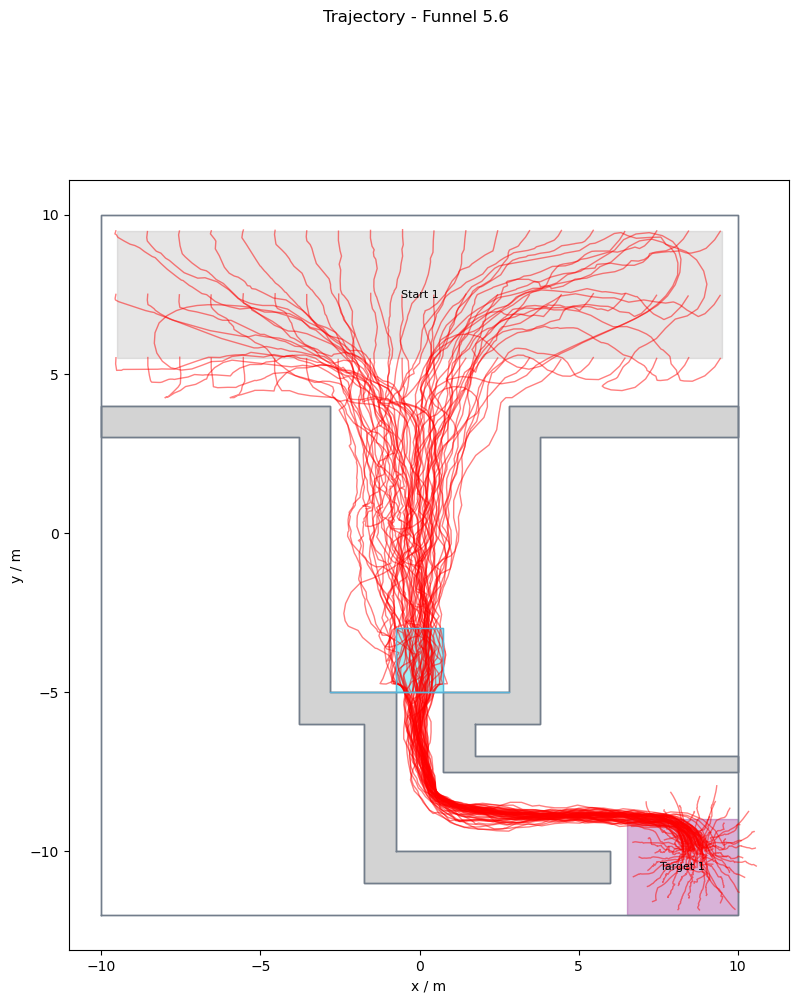

In [114]:
plot_trajectories(
    trajectories=funnel_5_6_traj, 
    walkable_area=funnel_5_6_area,  
    level_name=funnel_5_6_name, 
    final_targets=funnel_5_6_final_target, 
    start_areas=funnel_5_6_start_area,
    measurement_areas=funnel_5_6_measurement_areas,
    measurement_line=funnel_5_6_measurement_line
)

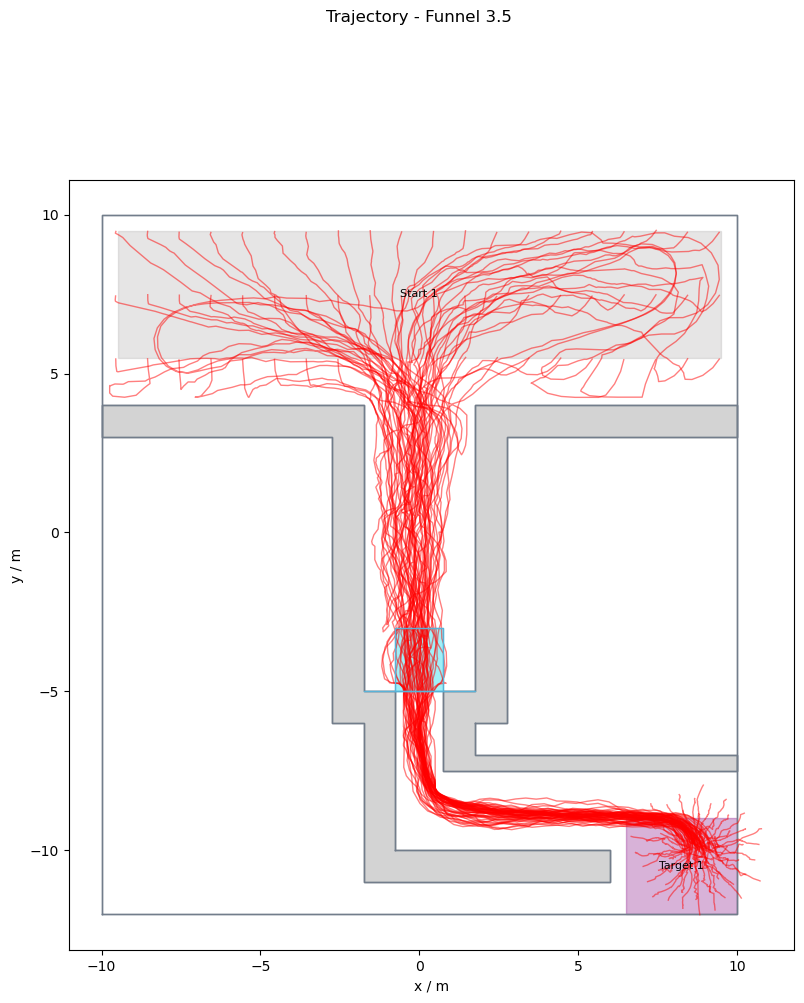

In [115]:
plot_trajectories(
    trajectories=funnel_3_5_traj, 
    walkable_area=funnel_3_5_area,  
    level_name=funnel_3_5_name, 
    final_targets=funnel_3_5_final_target, 
    start_areas=funnel_3_5_start_area,
    measurement_areas=funnel_3_5_measurement_areas,
    measurement_line=funnel_3_5_measurement_line
)

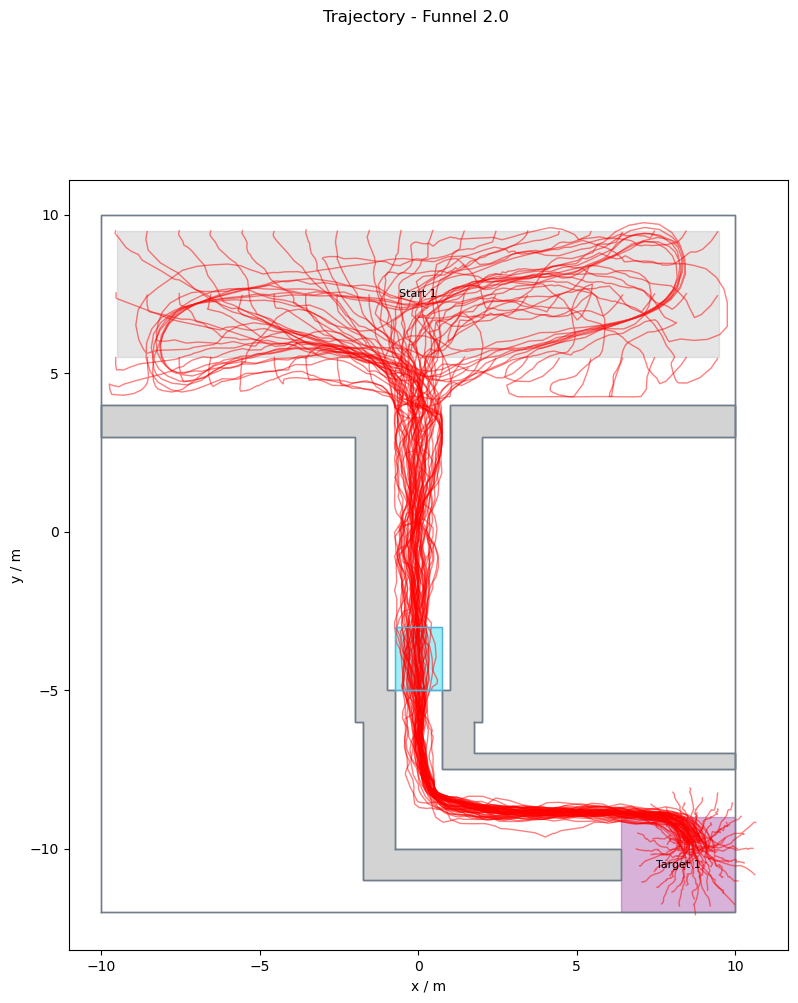

In [116]:
plot_trajectories(
    trajectories=funnel_2_traj, 
    walkable_area=funnel_2_area,  
    level_name=funnel_2_name, 
    final_targets=funnel_2_final_target, 
    start_areas=funnel_2_start_area,
    measurement_areas=funnel_2_measurement_areas,
    measurement_line=funnel_2_measurement_line
)

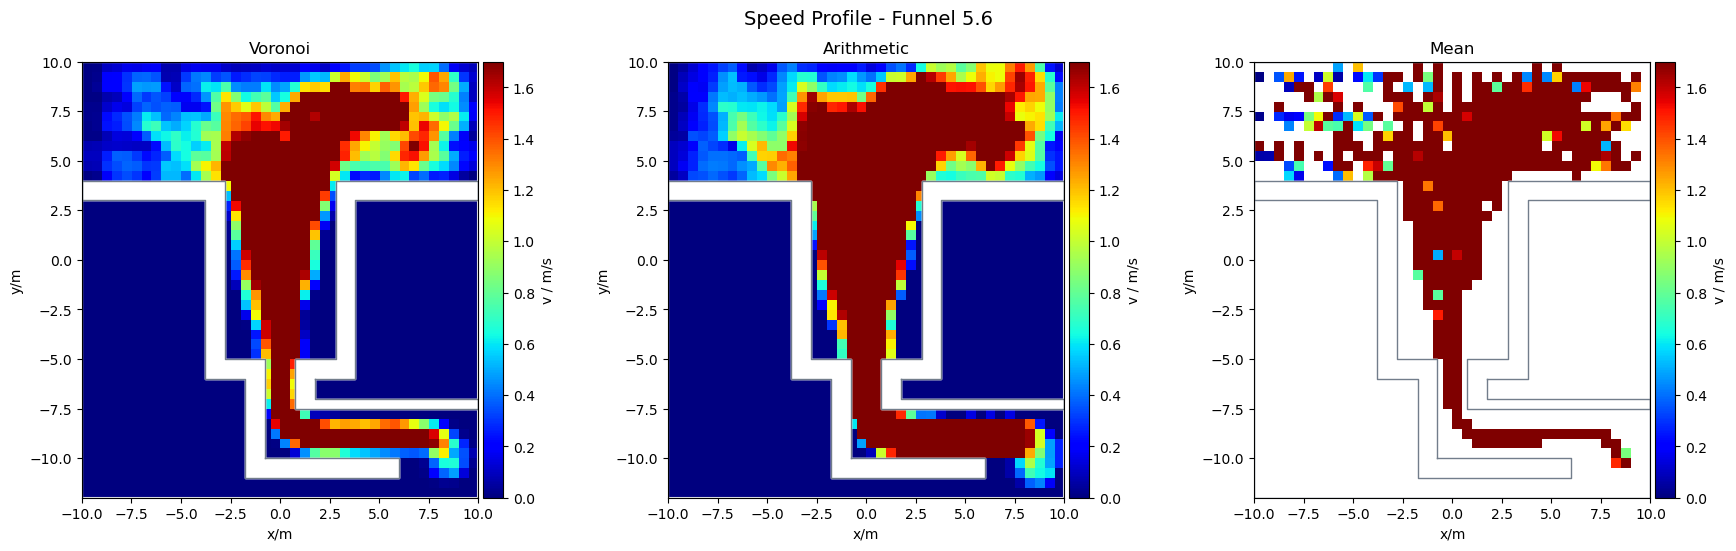

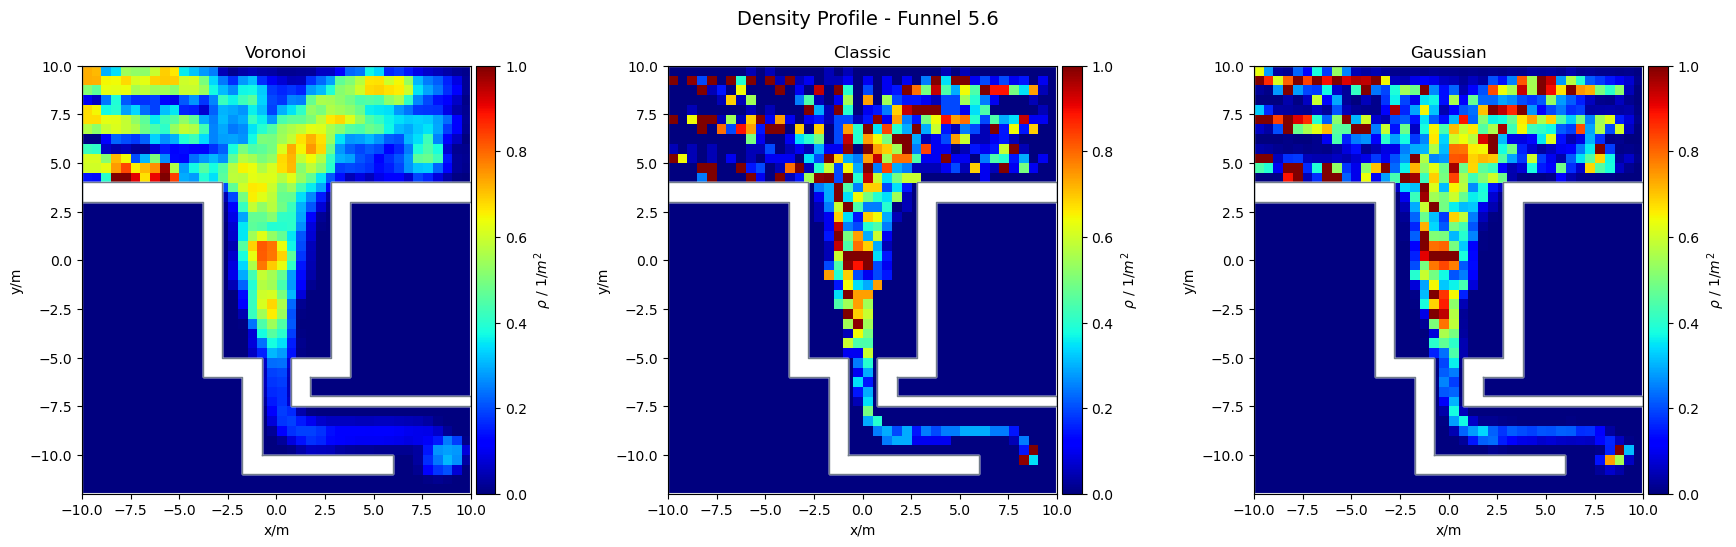

In [117]:
plot_speed_and_density_profiles(
    traj_data=funnel_5_6_traj[0],
    area=funnel_5_6_area, 
    density_max=1,
    level_name=funnel_5_6_name,
    min_frame=0,
    max_frame=80
)

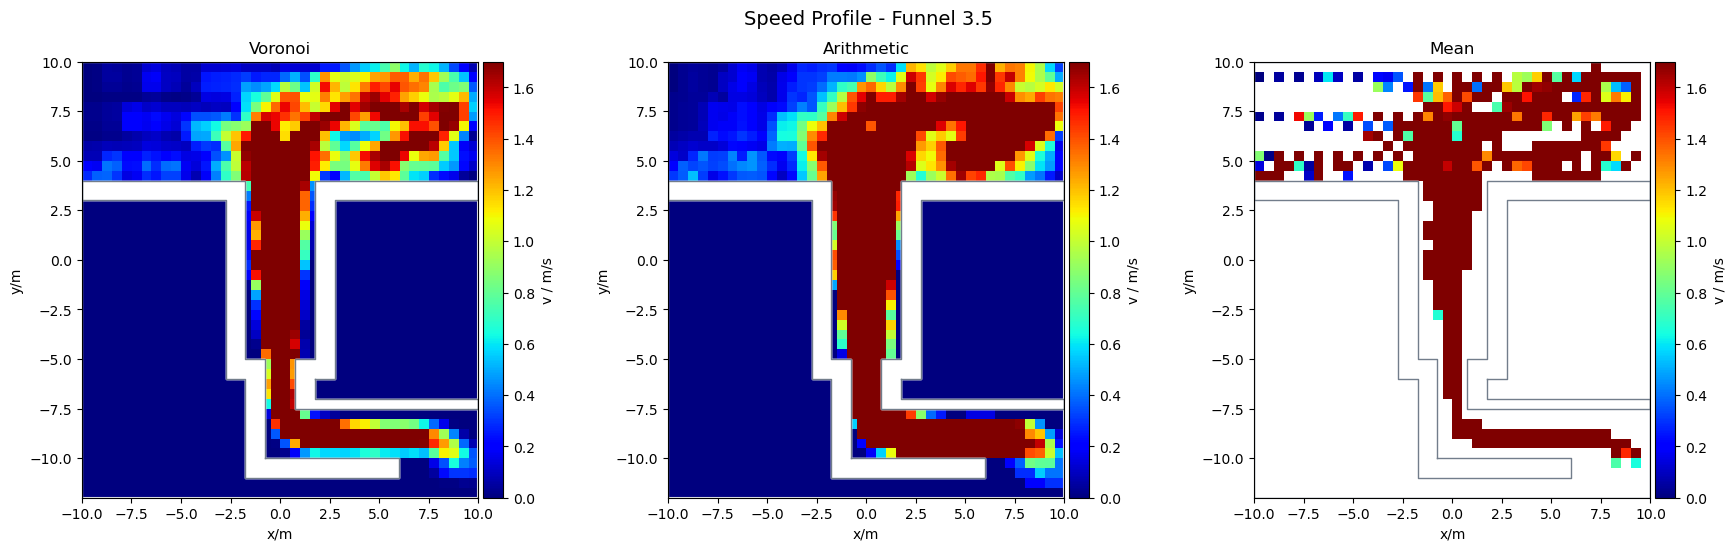

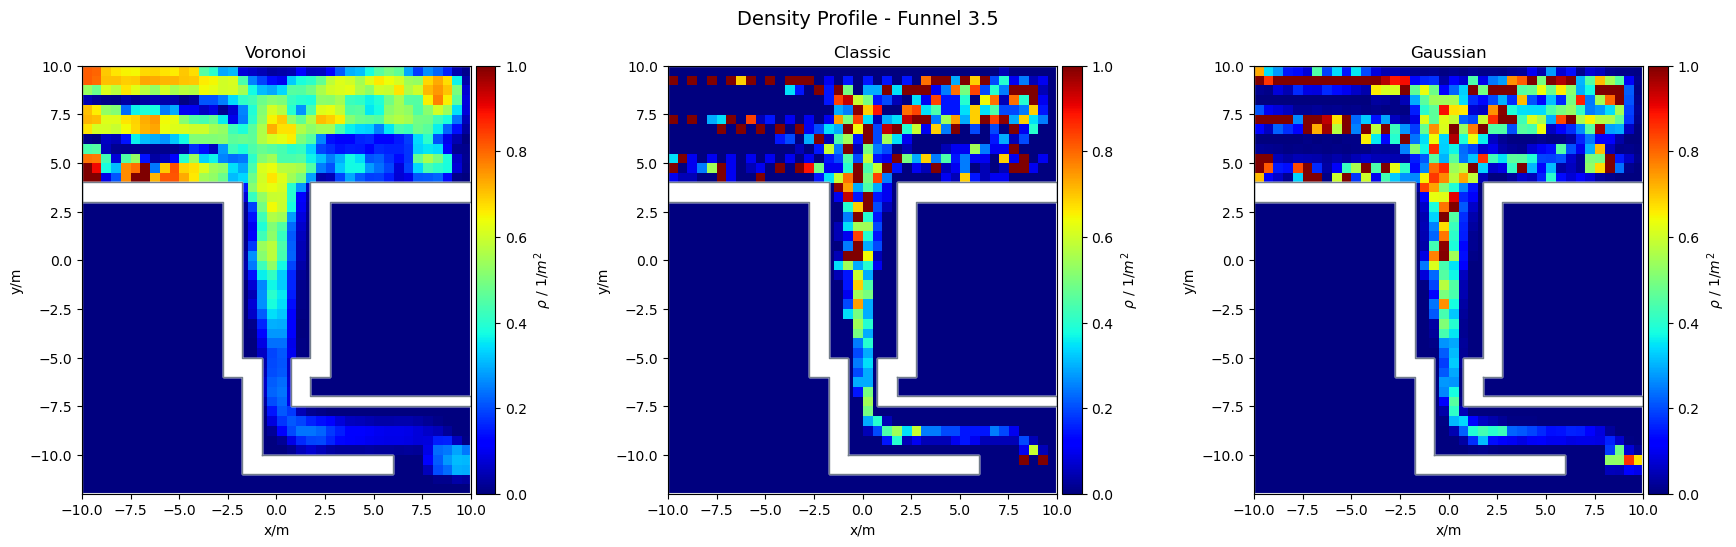

In [118]:
plot_speed_and_density_profiles(
    traj_data=funnel_3_5_traj[0],
    area=funnel_3_5_area, 
    density_max=1,
    level_name=funnel_3_5_name,
    min_frame=0,
    max_frame=80
)

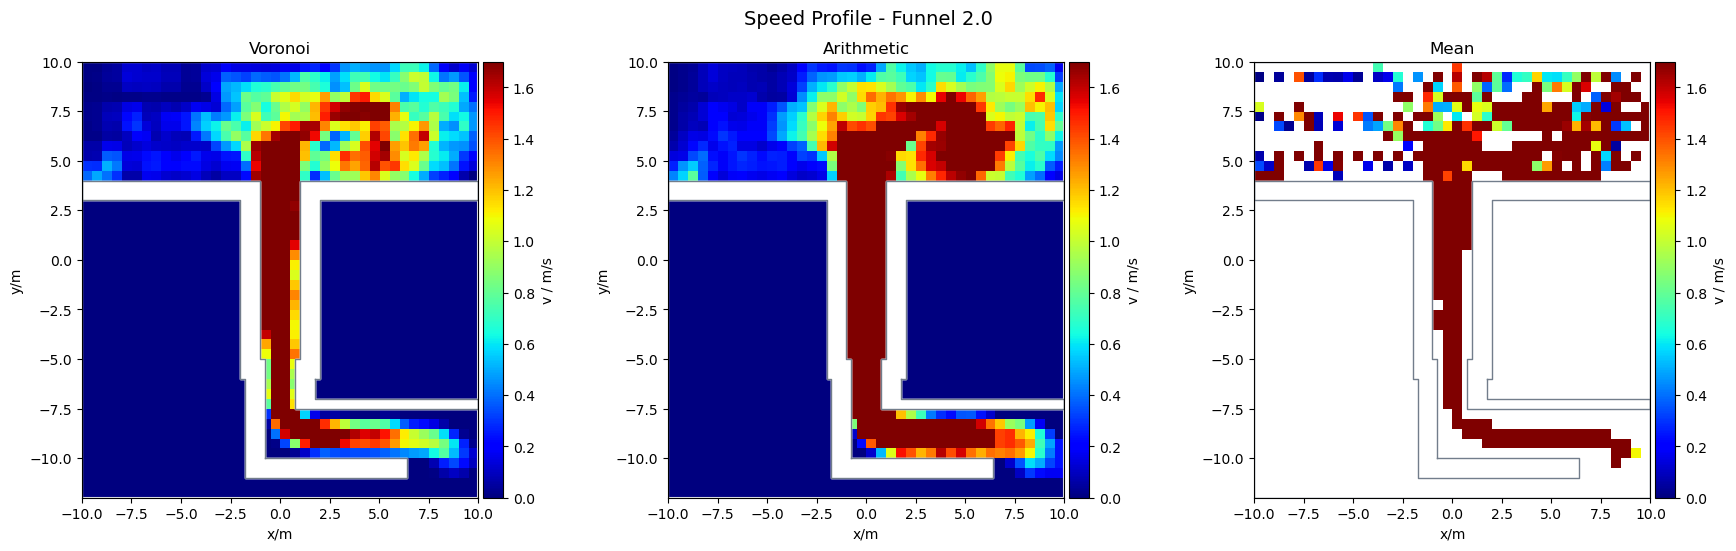

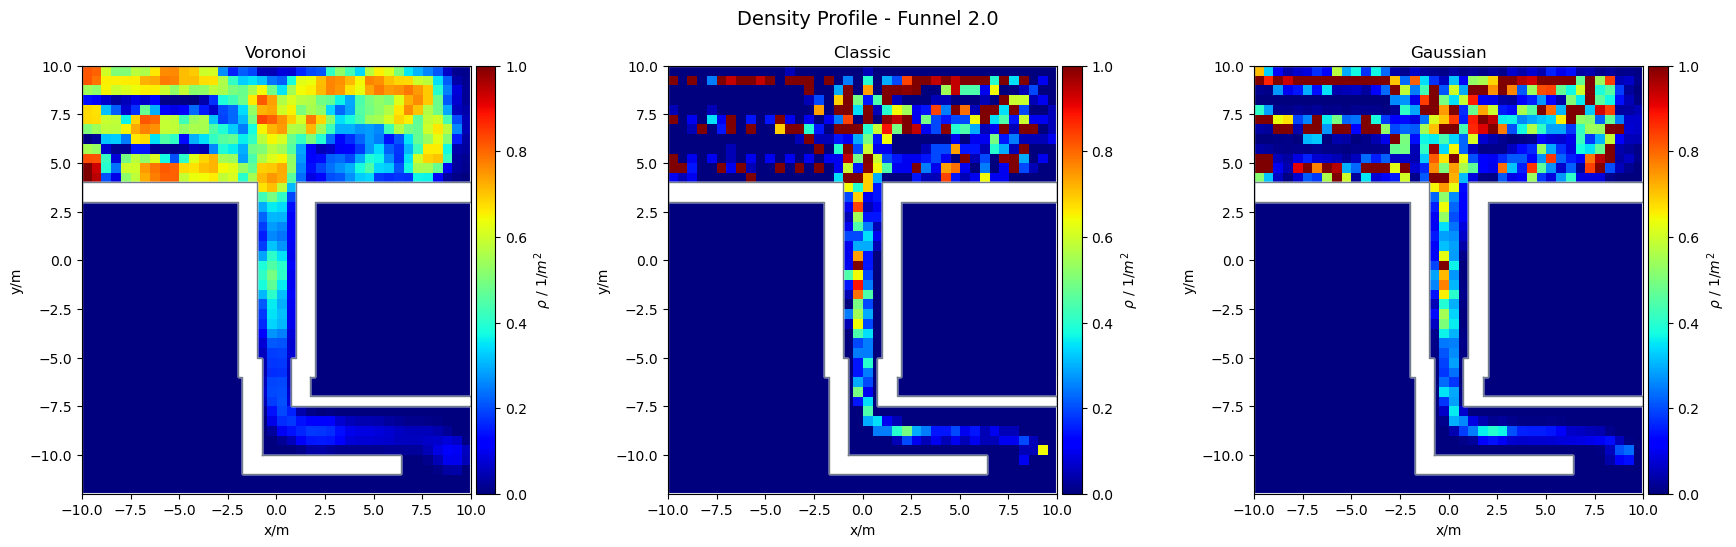

In [119]:
plot_speed_and_density_profiles(
    traj_data=funnel_2_traj[0],
    area=funnel_2_area, 
    density_max=1,
    level_name=funnel_2_name,
    min_frame=0,
    max_frame=80
)

In [120]:
comparison_voronoi_funnel = {
    "Voronoi Density Funnel 5.6": funnel_5_6_density_voronoi,
    "Voronoi Density Funnel 3.5": funnel_3_5_density_voronoi,
    "Voronoi Density Funnel 2.0": funnel_2_density_voronoi
}

comparison_voronoi_funnel_colors = {
    "Voronoi Density Funnel 5.6": "red",
    "Voronoi Density Funnel 3.5": "green",
    "Voronoi Density Funnel 2.0": "blue",
}

comparison_funnel_name = "Comparison Funnels"

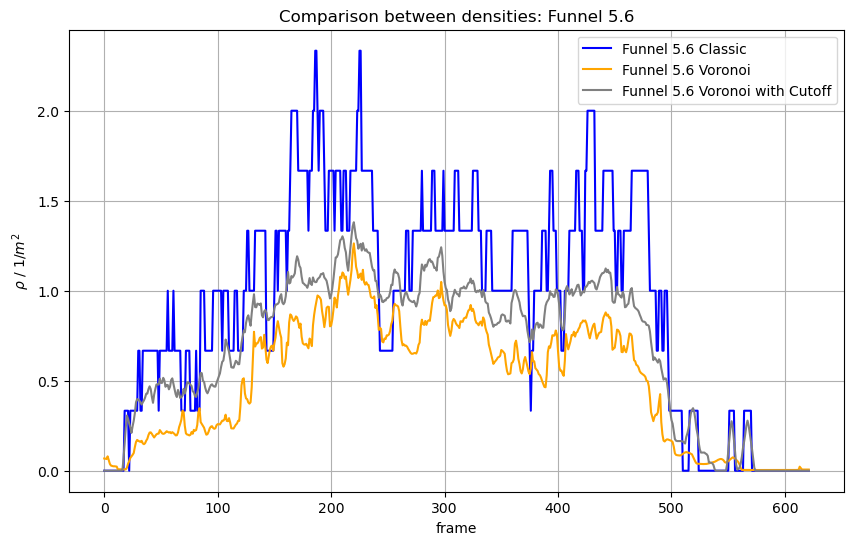

In [154]:
plot_density_comparison(funnel_5_6_data, funnel_5_6_colors, funnel_5_6_name, comparison_funnel_name)

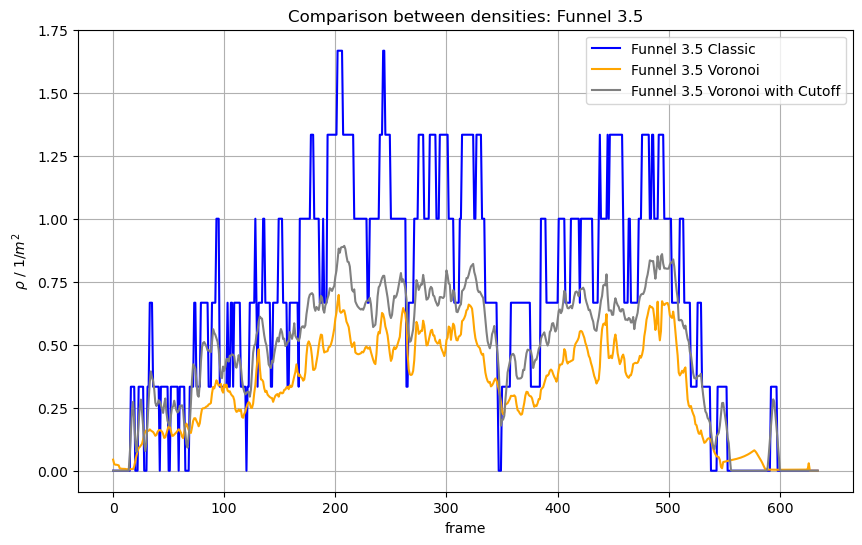

In [155]:
plot_density_comparison(funnel_3_5_data, funnel_3_5_colors, funnel_3_5_name, comparison_funnel_name)

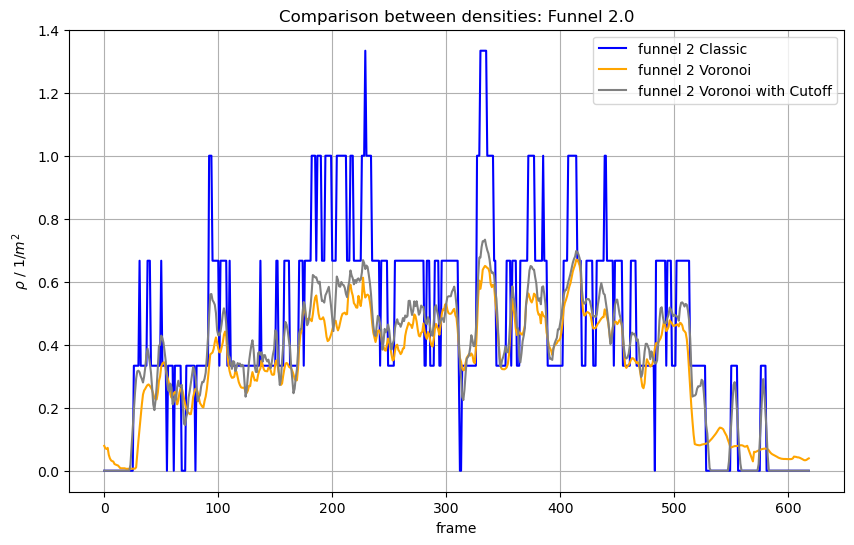

In [156]:
plot_density_comparison(funnel_2_data, funnel_2_colors, funnel_2_name, comparison_funnel_name)

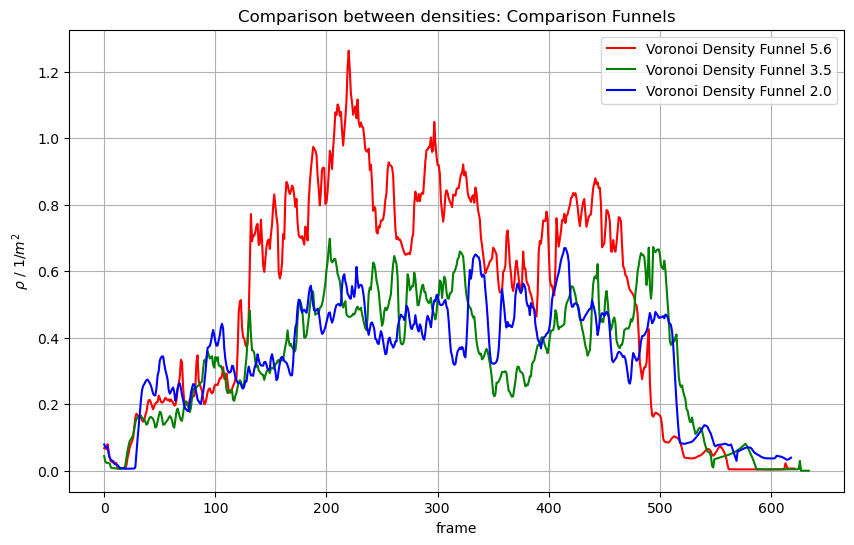

In [157]:
plot_density_comparison(comparison_voronoi_funnel, comparison_voronoi_funnel_colors, comparison_funnel_name, comparison_funnel_name)

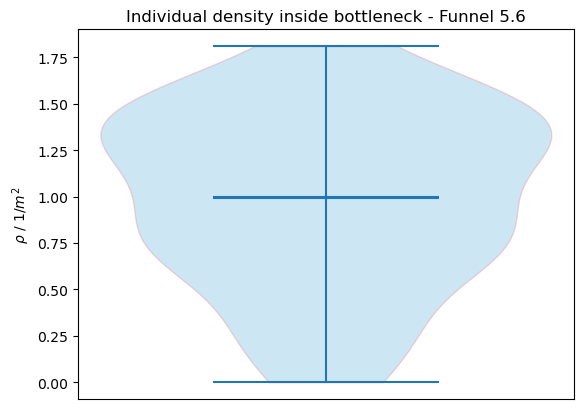

In [125]:
level_name = funnel_5_6_name
plot_density_distribution(
    density=funnel_5_6_passing_density, 
    title=f"Individual density inside bottleneck - {level_name}"
)   
path = f'../output/runs/{run}/plots/{level_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'individual_density_{run}.png')
plt.show()

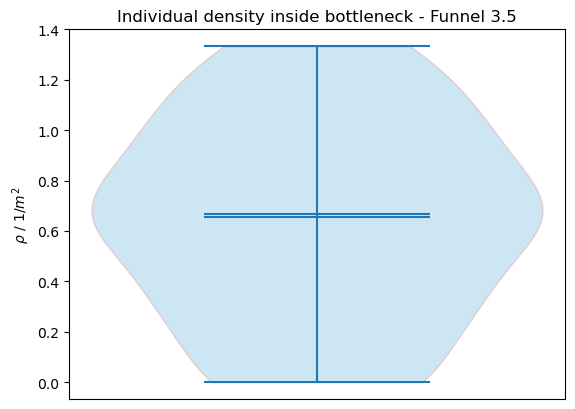

In [126]:
level_name = funnel_3_5_name
plot_density_distribution(
    density=funnel_3_5_passing_density, 
    title=f"Individual density inside bottleneck - {level_name}"
)   
path = f'../output/runs/{run}/plots/{level_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'individual_density_{run}.png')
plt.show()

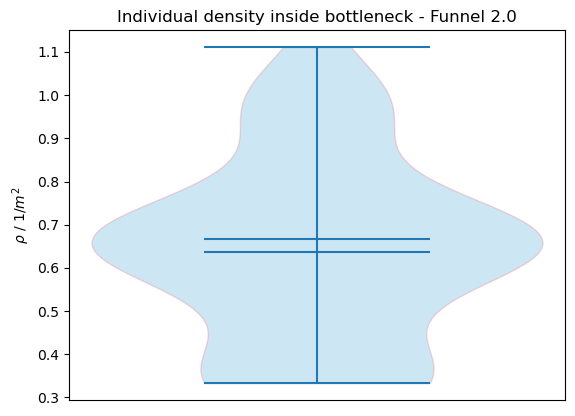

In [127]:
level_name = funnel_2_name
plot_density_distribution(
    density=funnel_2_passing_density, 
    title=f"Individual density inside bottleneck - {level_name}"
)   
path = f'../output/runs/{run}/plots/{level_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'individual_density_{run}.png')
plt.show()

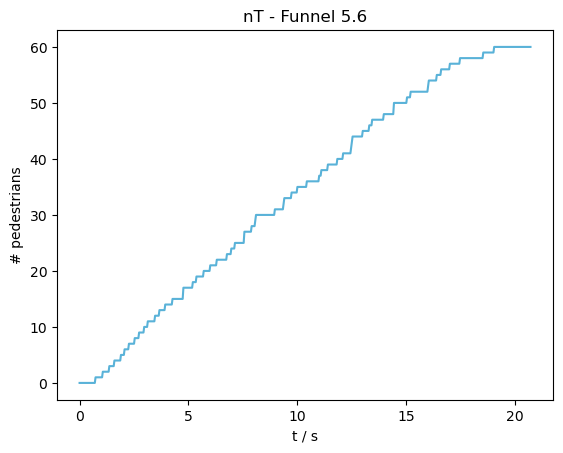

In [128]:

plot_nt(
    nt=funnel_5_6_nt,
    title=f"nT - {funnel_5_6_name}"
)
path = f'../output/runs/{run}/plots/{funnel_5_6_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'nT_{run}.png')
plt.show()

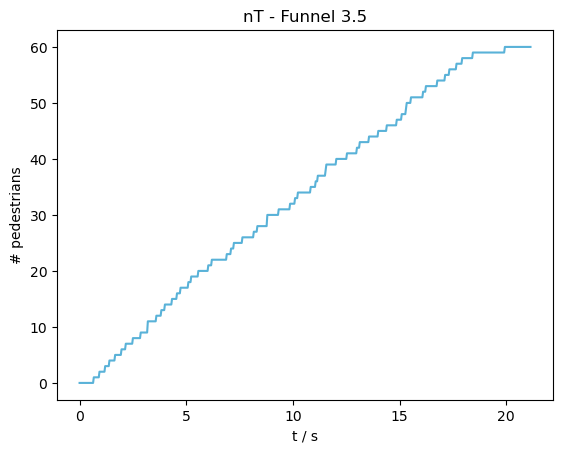

In [129]:
plot_nt(
    nt=funnel_3_5_nt,
    title=f"nT - {funnel_3_5_name}"
)
path = f'../output/runs/{run}/plots/{funnel_3_5_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'nT_{run}.png')
plt.show()

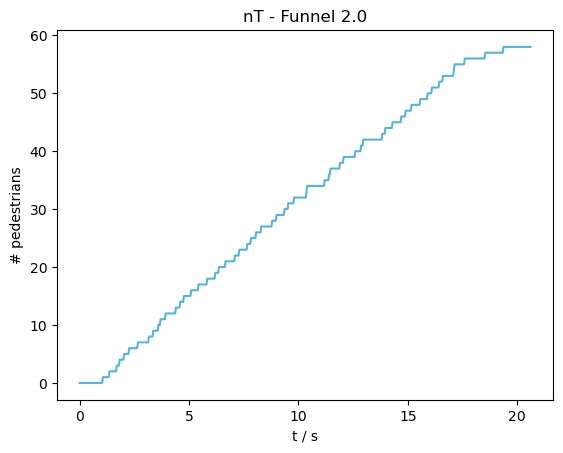

In [130]:
plot_nt(
    nt=funnel_2_nt,
    title=f"nT - {funnel_2_name}"
)
path = f'../output/runs/{run}/plots/{funnel_2_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'nT_{run}.png')
plt.show()

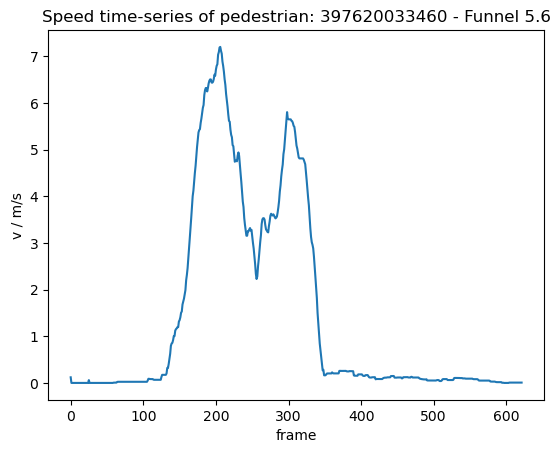

In [131]:
funnel_5_6_individual_speed_single_sided = plot_individual_speed(
    ped_id=funnel_5_6_first_id,
    level_name=funnel_5_6_name,
    speed=funnel_5_6_individual_speed_single_sided
)

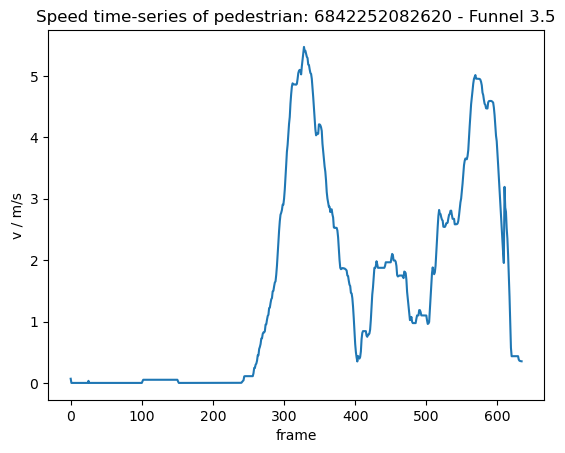

In [132]:
funnel_3_5_individual_speed_single_sided = plot_individual_speed(
    ped_id=funnel_3_5_first_id,
    level_name=funnel_3_5_name,
    speed=funnel_3_5_individual_speed_single_sided
)

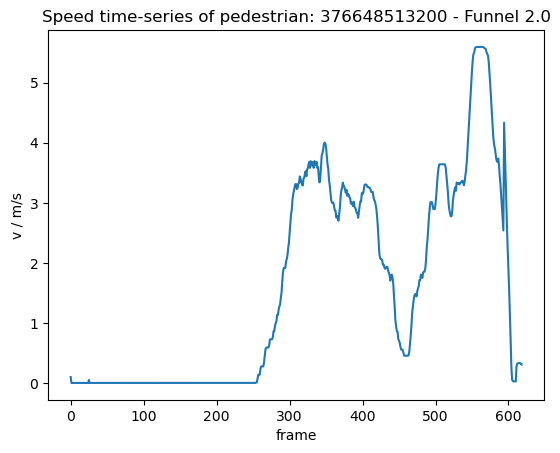

In [133]:
funnel_2_individual_speed_single_sided = plot_individual_speed(
    ped_id=funnel_2_first_id,
    level_name=funnel_2_name,
    speed=funnel_2_individual_speed_single_sided
)

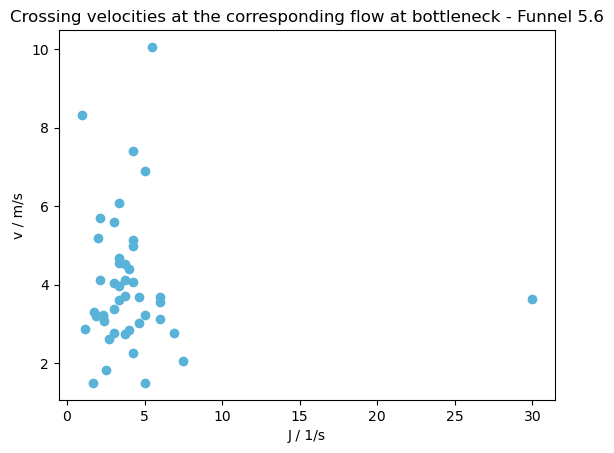

In [134]:
plot_flow(
    flow=funnel_5_6_flow,
    title=f"Crossing velocities at the corresponding flow at bottleneck - {funnel_5_6_name}",
)
path = f'../output/runs/{run}/plots/{funnel_5_6_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'flow_{run}.png')
plt.show()

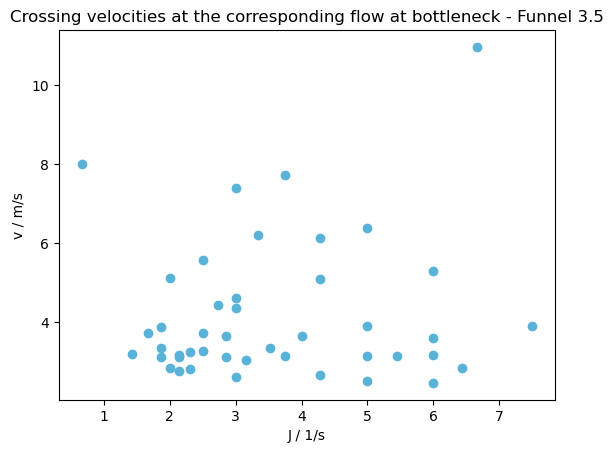

In [135]:
plot_flow(
    flow=funnel_3_5_flow,
    title=f"Crossing velocities at the corresponding flow at bottleneck - {funnel_3_5_name}",
)
path = f'../output/runs/{run}/plots/{funnel_3_5_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'flow_{run}.png')
plt.show()

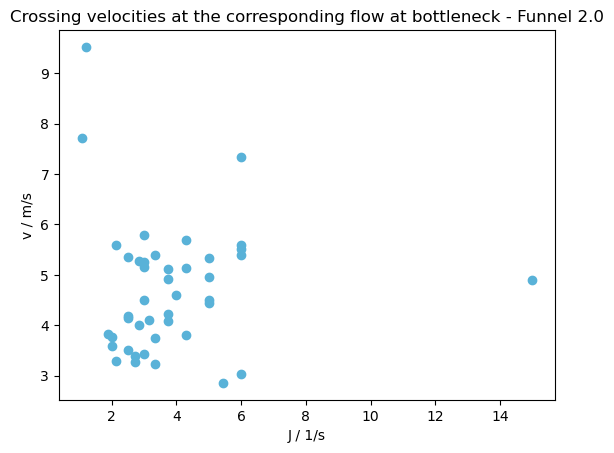

In [136]:
plot_flow(
    flow=funnel_2_flow,
    title=f"Crossing velocities at the corresponding flow at bottleneck - {funnel_2_name}",
)
path = f'../output/runs/{run}/plots/{funnel_2_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'flow_{run}.png')
plt.show()

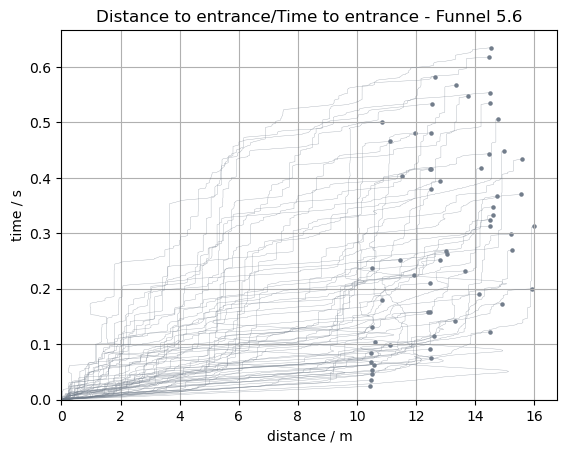

In [137]:
plot_time_distance(
    time_distance=funnel_5_6_df_time_distance,
    title=f"Distance to entrance/Time to entrance - {funnel_5_6_name}",
    frame_rate=funnel_5_6_traj[0].frame_rate,
)
path = f'../output/runs/{run}/plots/{funnel_5_6_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'distance_time_to_entrance_{run}.png')
plt.show()

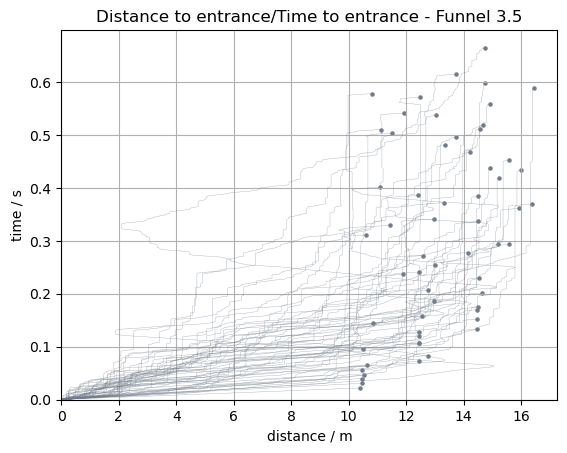

In [138]:
plot_time_distance(
    time_distance=funnel_3_5_df_time_distance,
    title=f"Distance to entrance/Time to entrance - {funnel_3_5_name}",
    frame_rate=funnel_3_5_traj[0].frame_rate,
)
path = f'../output/runs/{run}/plots/{funnel_3_5_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'distance_time_to_entrance_{run}.png')
plt.show()

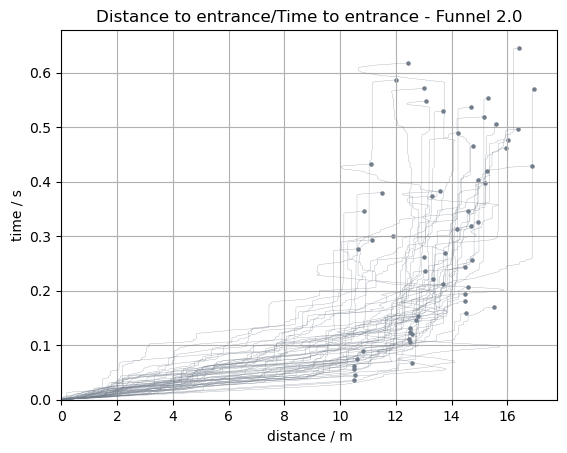

In [139]:
plot_time_distance(
    time_distance=funnel_2_df_time_distance,
    title=f"Distance to entrance/Time to entrance - {funnel_2_name}",
    frame_rate=funnel_2_traj[0].frame_rate,
)
path = f'../output/runs/{run}/plots/{funnel_2_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'distance_time_to_entrance_{run}.png')
plt.show()

# Pedestrian flow through multiple bottlenecks

### Corner Connection

In [140]:
# Define the complete area and obstacles
complete_area = Polygon([(16, -20), (16, 10), (-16, 10), (-16, -20)])

obstacles = [
    #top barrier
    Polygon([(-15.5, 9.5), (-4.5, 9.5), (-4.5, 0.5), (4.5, 0.5), (4.5, 9.5), 
             (15.5, 9.5), (15.5, 9), (5, 9), (5, 0), (-5, 0), (-5, 9), (-15.5, 9)]), 
    #left barrier
    Polygon([(-15.5, 8.999), (-15.5, -1.5), (-5.5, -1.5), (-5.5, -10.5), (-5, -10.5), (-1.5, -10.5), (-1.5, -14.5), (-1, -14.5), (-1, -10), (-5, -10), (-5, -1), (-15, -1), (-15, 8.999)]), 
    #right barrier
    Polygon([(15.5, 8.999), (15.5, -1.5), (5.5, -1.5), (5.5, -10.5), (5, -10.5), (1.5, -10.5), (1.5, -14.5), (1, -14.5), (1, -10), (5, -10), (5, -1), (15, -1), (15, 8.999)]), 
]

corner_final_target = [[(-1, -16), (1, -16), (1, -18), (-1, -18)]]
corner_start_area = [
    [(-14.5, 8.5), (-5.5, 8.5), (-5.5, -0.5), (-14.5, -0.5)],
    [(14.5, 8.5), (5.5, 8.5), (5.5, -0.5), (14.5, -0.5)],
]

# Create walkable area
obstacle = shapely.union_all(obstacles)
corner_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

# Extract trajectories
corner_traj = extract_trajectories(Path("../output/pedpy/CornerConnectionBatch.txt"))
corner_traj_unified = extract_trajectories_unified(Path("../output/pedpy/CornerConnectionBatch.txt"))

# Define measurement areas
corner_measurement_areas = {
    "left": MeasurementArea([(-7, -1), (-7, 1), (-5, 1), (-5, -1)]),
    "right": MeasurementArea([(7, -1), (7, 1), (5, 1), (5, -1)]),
    "center": MeasurementArea([(-1, -8), (-1, -6), (1, -6), (1, -8)]),
}

# Define measurement line
corner_measurement_line = MeasurementLine([(-2.0, -10.0), (2.0, -10.0)])

# Compute individual voronoi polygons
corner_individual_list = [compute_voronoi(traj, corner_area) for traj in corner_traj]
corner_individual_cutoff_list = [compute_voronoi(traj, corner_area, Cutoff(radius=1, quad_segments=3)) for traj in corner_traj]
corner_individual_list_unified = [compute_voronoi(corner_traj_unified[0], corner_area)]
corner_individual_cutoff_list_unified = [compute_voronoi(corner_traj_unified[0], corner_area, Cutoff(radius=1, quad_segments=3))]

# Compute classic density
corner_classic_density = {
    "left": compute_classic_density(traj_data=corner_traj[0], measurement_area=corner_measurement_areas["left"]),
    "right": compute_classic_density(traj_data=corner_traj[1], measurement_area=corner_measurement_areas["right"]),
    "center": compute_classic_density(traj_data=corner_traj_unified[0], measurement_area=corner_measurement_areas["center"]),
}

corner_classic_density["local"] = corner_classic_density["left"] + corner_classic_density["right"]
corner_classic_density["global"] = corner_classic_density["local"] + corner_classic_density["center"] 

corner_density_voronoi = {
    "left": compute_voronoi_density_list(corner_individual_list[0], corner_measurement_areas["left"]),
    "right": compute_voronoi_density_list(corner_individual_list[1], corner_measurement_areas["right"]),
    "center": compute_voronoi_density_list(corner_individual_list_unified[0], corner_measurement_areas["center"]),
}

corner_density_voronoi["local"] = corner_density_voronoi["left"] + corner_density_voronoi["right"]
corner_density_voronoi["global"] = corner_density_voronoi["local"] + corner_density_voronoi["center"] 

corner_density_voronoi_cutoff = {
    "left": compute_voronoi_density_list(corner_individual_cutoff_list[0], corner_measurement_areas["left"]),
    "right": compute_voronoi_density_list(corner_individual_cutoff_list[1], corner_measurement_areas["right"]),
    "center": compute_voronoi_density_list(corner_individual_cutoff_list_unified[0], corner_measurement_areas["center"]),
}

corner_density_voronoi_cutoff["local"] = corner_density_voronoi_cutoff["left"] + corner_density_voronoi_cutoff["right"]
corner_density_voronoi_cutoff["global"] = corner_density_voronoi_cutoff["local"] + corner_density_voronoi_cutoff["center"]
# Compute flow calculation
corner_nt, _ = compute_n_t(
    traj_data=corner_traj_unified[0],
    measurement_line=corner_measurement_line,
)

corner_name = "Corner Connection"

### Center Connection

In [141]:
# Define the complete area and obstacles
complete_area = Polygon([(16, -16), (16, 6), (-16, 6), (-16, -16)])

obstacles = [
    Polygon([(-15.5, 5.5), (-5, 5.5), (-5, 0.5), (-5.5, 0.5), (-5.5, 5), (-15, 5), (-15, -5), (-5.5, -5), (-5.5, -0.5), (-5, -0.5), (-5, -5.5), (-15.5, -5.5)]), #left
    Polygon([(15.5, 5.5), (5, 5.5), (5, 0.5), (5.5, 0.5), (5.5, 5), (15, 5), (15, -5), (5.5, -5), (5.5, -0.5), (5, -0.5), (5, -5.5), (15.5, -5.5)]), #right
    Polygon([(-5, 5.5), (5, 5.5), (5, 5), (-5, 5)]), #top
    Polygon([(-4.99, -5.49), (-1.5, -5.49), (-1.5, -10), (-1, -10), (-1, -4.99), (-4.99, -4.99)]), #right
    Polygon([(4.99, -5.49), (1.5, -5.49), (1.5, -10), (1, -10), (1, -4.99), (4.99, -4.99)]), #left
    ]

center_final_target = [[(-1, -11.5), (-1, -12.5), (1, -12.5), (1, -11.5)]]
center_start_area = [
    [(-7.5, 4.25), (-14.5, 4.25), (-14.5, -4.25), (-7.5, -4.25)],
    [(7.5, 4.25), (14.5, 4.25), (14.5, -4.25), (7.5, -4.25)]
]

# Create walkable area
obstacle = shapely.union_all(obstacles)
center_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

# Extract trajectories
center_traj = extract_trajectories(Path("../output/pedpy/CenterConnectionBatch.txt"))
center_traj_unified = extract_trajectories_unified(Path("../output/pedpy/CenterConnectionBatch.txt"))

# Define measurement areas
center_measurement_areas = {
    "left": MeasurementArea([(-5.5, -1), (-5.5, 1), (-7.5, 1), (-7.5, -1)]),
    "right": MeasurementArea([(5.5, -1), (5.5, 1), (7.5, 1), (7.5, -1)]),
    "center": MeasurementArea([(-1, -1), (-1, -3), (1, -3), (1, -1)]),
}

center_measurement_line = MeasurementLine([(-2.0, -5.0), (2.0, -5.0)])

# Compute individual voronoi polygons
center_individual_list = [compute_voronoi(traj, center_area) for traj in center_traj]
center_individual_cutoff_list = [compute_voronoi(traj, center_area, Cutoff(radius=1, quad_segments=3)) for traj in center_traj]
center_individual_list_unified = [compute_voronoi(center_traj_unified[0], center_area)]
center_individual_cutoff_list_unified = [compute_voronoi(center_traj_unified[0], center_area, Cutoff(radius=1, quad_segments=3))]

# Compute classic density
center_classic_density = {
    "left": compute_classic_density(traj_data=center_traj[0], measurement_area=center_measurement_areas["left"]),
    "right": compute_classic_density(traj_data=center_traj[1], measurement_area=center_measurement_areas["right"]),
    "center": compute_classic_density(traj_data=center_traj_unified[0], measurement_area=center_measurement_areas["center"]),
}

center_classic_density["local"] = center_classic_density["left"] + center_classic_density["right"]
center_classic_density["global"] = center_classic_density["local"] + center_classic_density["center"]

center_density_voronoi = {
    "left": compute_voronoi_density_list(center_individual_list[0], center_measurement_areas["left"]),
    "right": compute_voronoi_density_list(center_individual_list[1], center_measurement_areas["right"]),
    "center": compute_voronoi_density_list(center_individual_list_unified[0], center_measurement_areas["center"]),
}

center_density_voronoi["local"] = center_density_voronoi["left"] + center_density_voronoi["right"]
center_classic_density["global"] = center_density_voronoi["local"] + center_density_voronoi["center"] 

center_density_voronoi_cutoff = {
    "left": compute_voronoi_density_list(center_individual_cutoff_list[0], center_measurement_areas["left"]),
    "right": compute_voronoi_density_list(center_individual_cutoff_list[1], center_measurement_areas["right"]),
    "center": compute_voronoi_density_list(center_individual_cutoff_list_unified[0], center_measurement_areas["center"]),
}

center_density_voronoi_cutoff["local"] = center_density_voronoi_cutoff["left"] + center_density_voronoi_cutoff["right"]
center_density_voronoi_cutoff["global"] = center_density_voronoi_cutoff["local"] + center_density_voronoi_cutoff["center"] 

# Compute flow calculation
center_nt, _ = compute_n_t(
    traj_data=center_traj_unified[0],
    measurement_line=center_measurement_line,
)

center_name = "Center Connection"

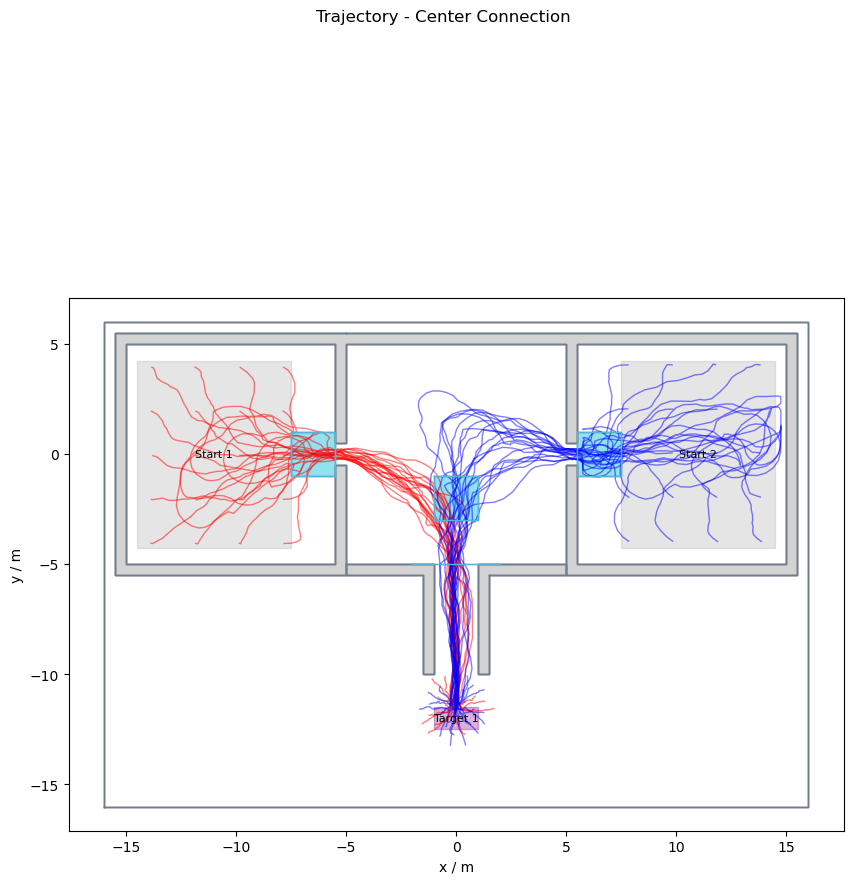

In [142]:
plot_trajectories(
    center_traj, 
    center_area, 
    center_name, 
    center_final_target, 
    center_start_area,
    center_measurement_areas,
    center_measurement_line
)

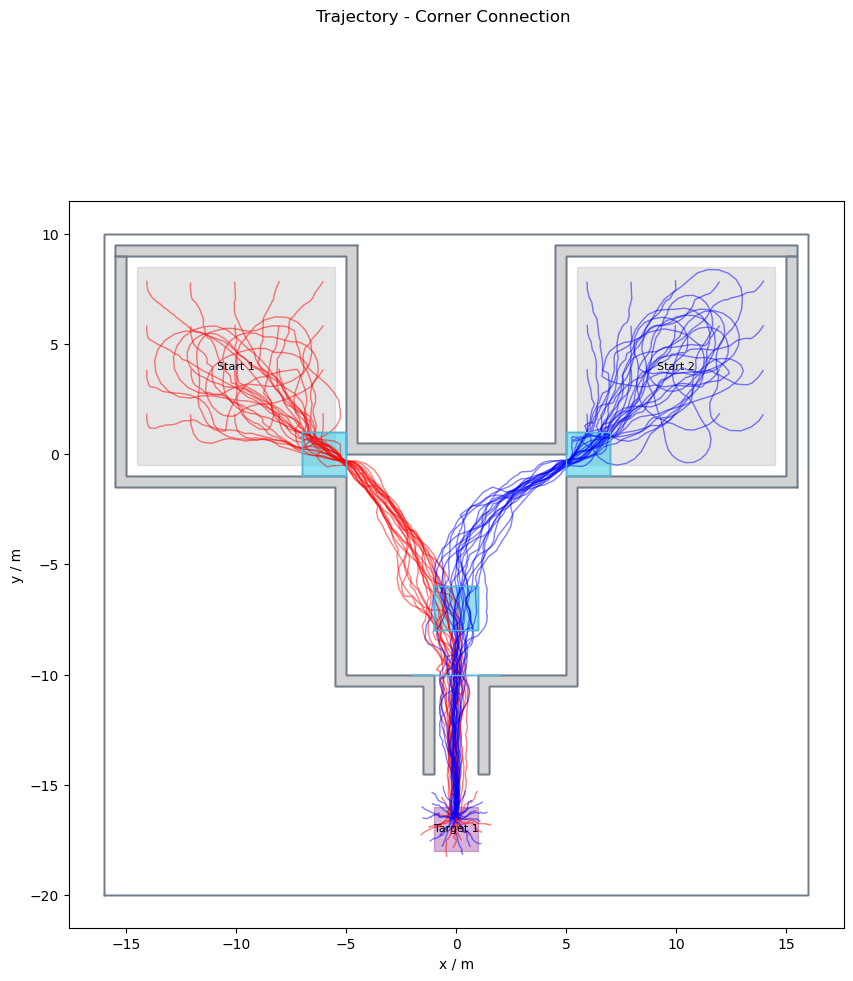

In [143]:
plot_trajectories(
    corner_traj, 
    corner_area, 
    corner_name, 
    corner_final_target, 
    corner_start_area,
    corner_measurement_areas,
    corner_measurement_line
)

In [159]:
comparison_connection_local = {
    "Local Density Center Connection": center_density_voronoi_cutoff["local"],
    "Local Density Corner Connection": corner_density_voronoi_cutoff["local"],
}

comparison_connection_local_colors = {
    "Local Density Center Connection": "#3649A2",
    "Local Density Corner Connection": "#DD4444"
}

comparison_connection_center = {
    "Density in front of bottleneck Center Connection": center_density_voronoi_cutoff["center"],
    "Density in front of bottleneck Corner Connection": corner_density_voronoi_cutoff["center"],
}

comparison_connection_center_colors = {
    "Density in front of bottleneck Center Connection": "#3649A2",
    "Density in front of bottleneck Corner Connection": "#DD4444"
}

comparison_connection_global = {
    "Global Density Center Connection": center_density_voronoi_cutoff["global"],
    "Global Density Corner Connection": corner_density_voronoi_cutoff["global"],
}

comparison_connection_global_colors = {
    "Global Density Center Connection": "#3649A2",
    "Global Density Corner Connection": "#DD4444"
}

comparison_global_name = "Global"
comparison_local_name = "Local"
comparison_center_name = "In front of bottleneck"
comparison_main_folder = "Comparison Connection"

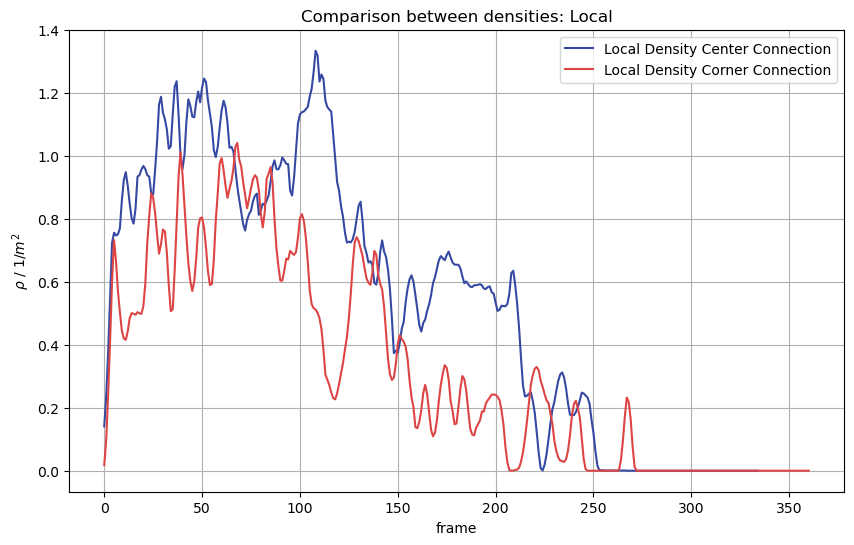

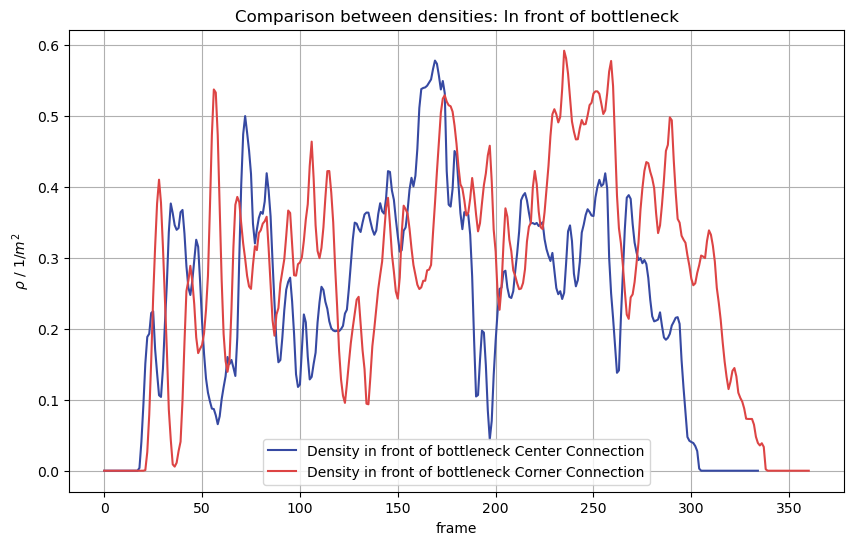

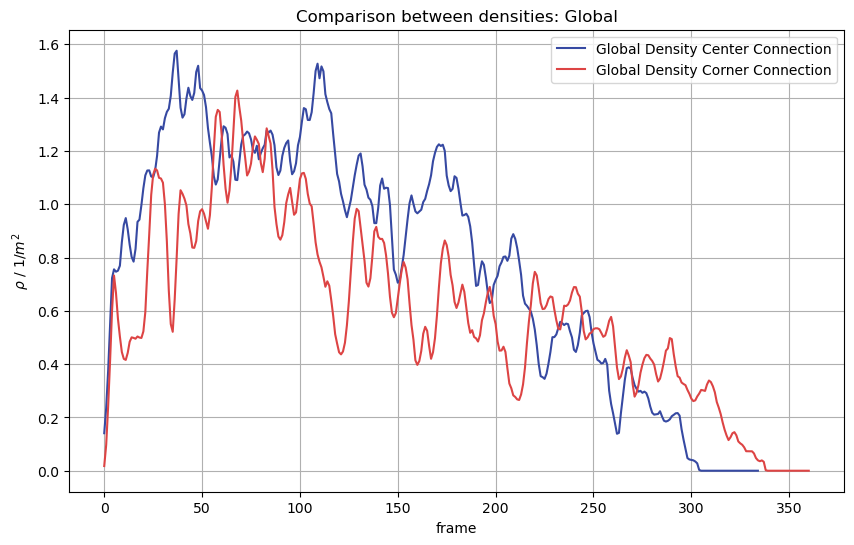

In [160]:
plot_density_comparison(comparison_connection_local, comparison_connection_local_colors, comparison_local_name, comparison_main_folder)
plot_density_comparison(comparison_connection_center, comparison_connection_center_colors, comparison_center_name, comparison_main_folder)
plot_density_comparison(comparison_connection_global, comparison_connection_global_colors, comparison_global_name, comparison_main_folder)

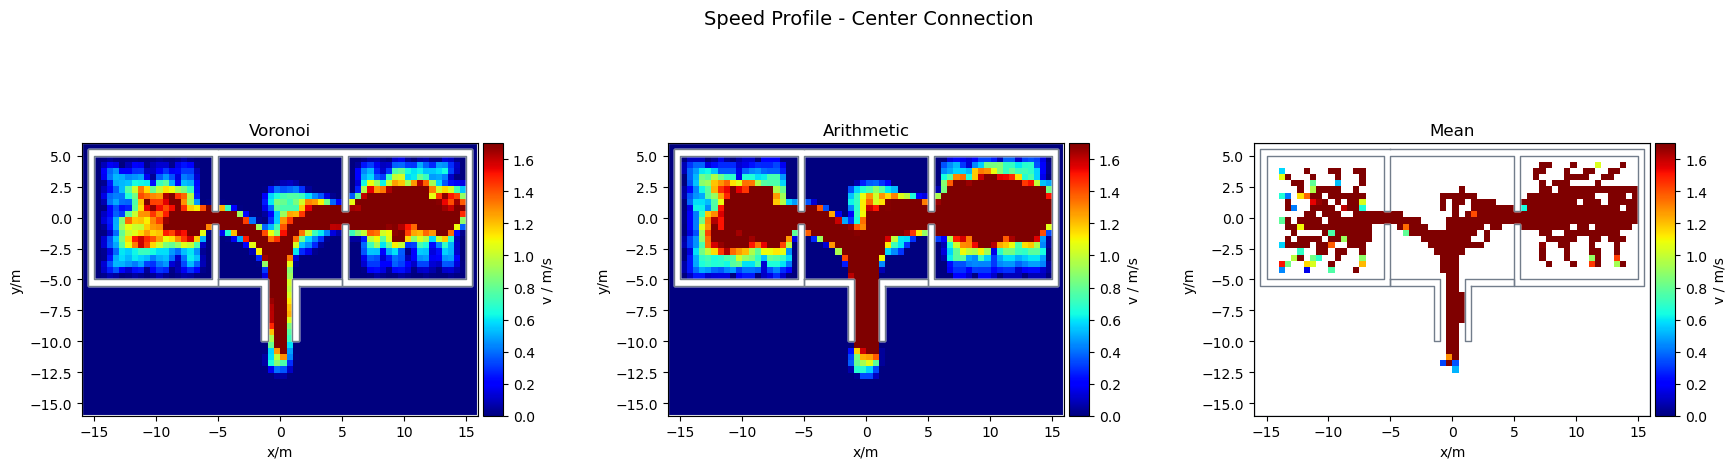

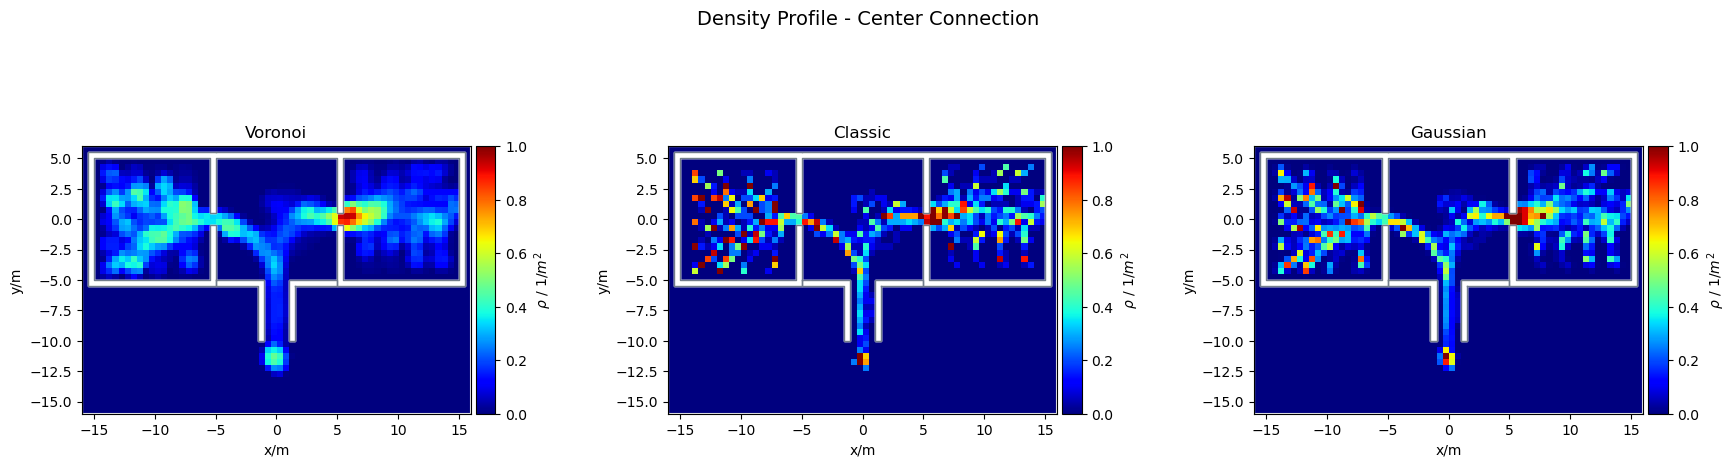

In [146]:
plot_speed_and_density_profiles(
    center_traj_unified[0],
    center_area, 
    1,
    center_name,
    0,
    80
)

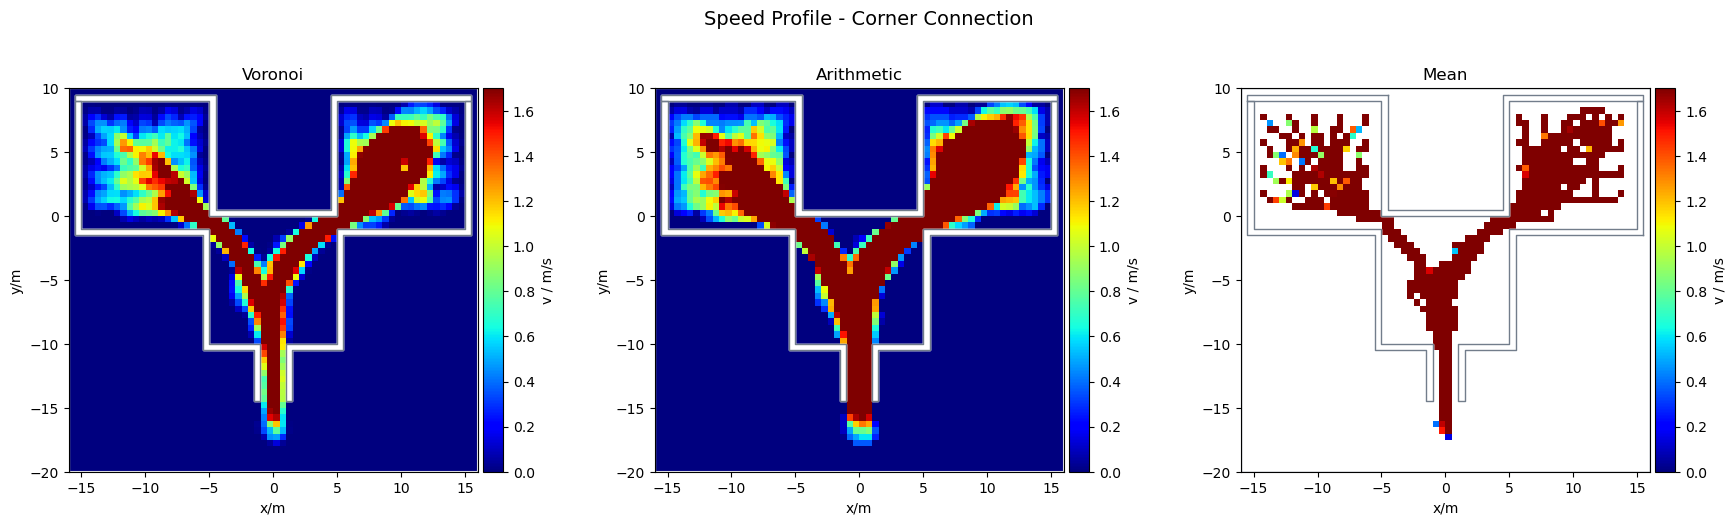

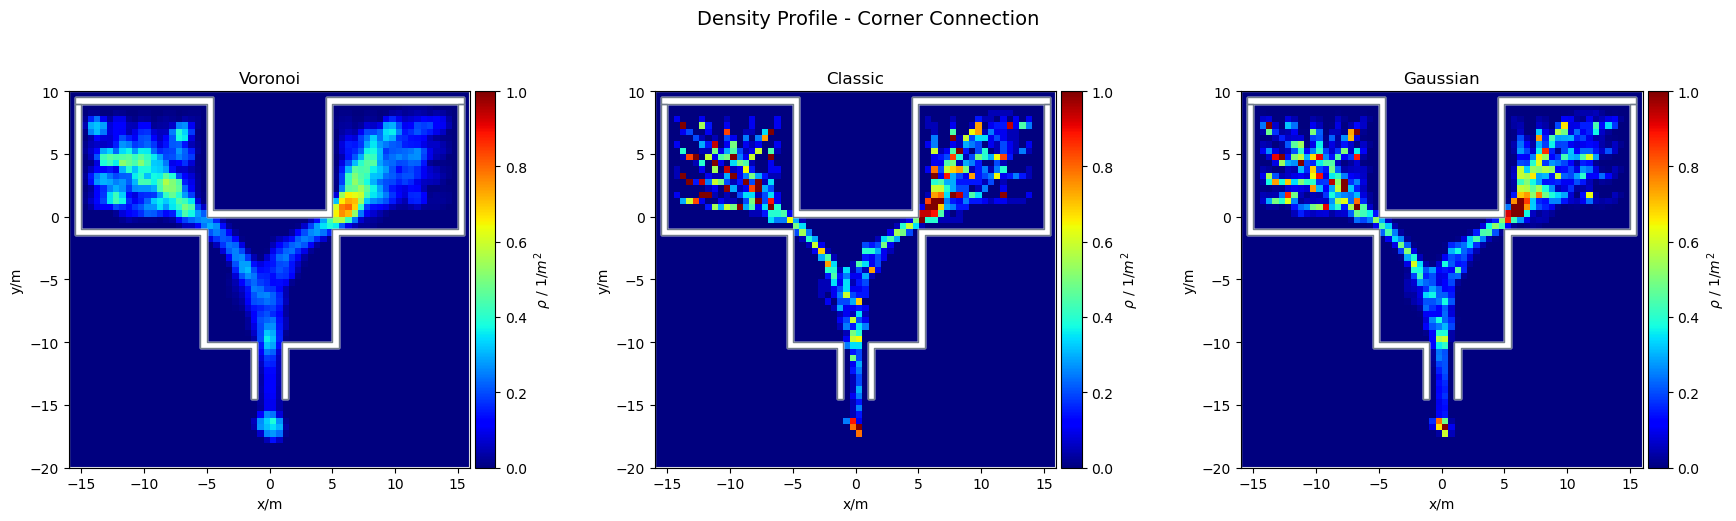

In [147]:
plot_speed_and_density_profiles(
    corner_traj_unified[0], 
    corner_area, 
    1,
    corner_name,
    0,
    80
)

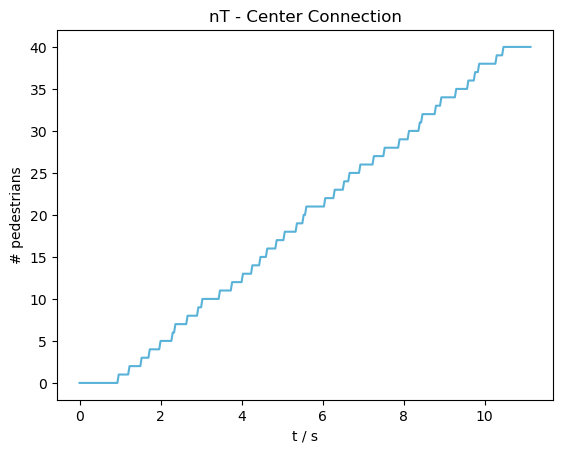

In [148]:
level_name = center_name
plot_nt(
    nt=center_nt,
    title=f"nT - {level_name}"
)
path = f'../output/runs/{run}/plots/{level_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'nT_{run}.png')
plt.show()

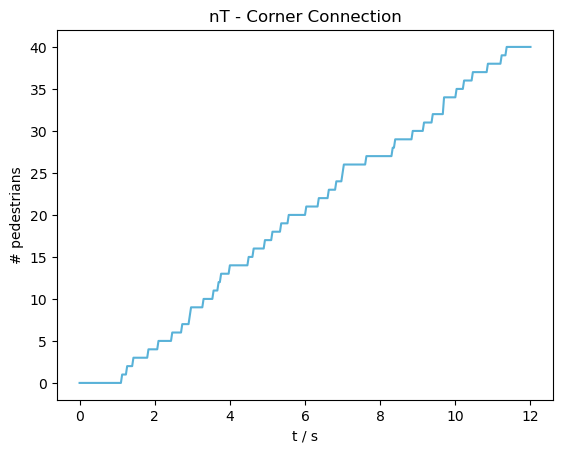

In [149]:
level_name = corner_name
plot_nt(
    nt=corner_nt,
    title=f"nT - {level_name}"
)
path = f'../output/runs/{run}/plots/{level_name}/'
os.makedirs(path, exist_ok=True)
plt.savefig(path + f'nT_{run}.png')
plt.show()

## Density Animation

In [150]:
# %matplotlib notebook
# 
# def plot_voronoi_density_animation(
#         voronoi_data_list: list, 
#         voronoi_data_cutoff_list: list, 
#         traj_data_list: list, 
#         walkable_area: WalkableArea, 
#         frame_start: int, 
#         frame_end: int, 
#         step: int, 
#         level_name: str, 
#         vmin: float, 
#         vmax: float) -> FuncAnimation:
#     frames = list(range(frame_start, frame_end + 1, step))
# 
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
#     fig.suptitle(f"Voronoi Density - {level_name}")
# 
#     def update(frame):
#         ax1.clear()
#         ax2.clear()
# 
#         ax1.set_title(f"Frame {frame} w/o cutoff")
#         ax1.set_aspect('equal')
#         for traj_data, voronoi_data in zip(traj_data_list, voronoi_data_list):
#             plot_voronoi_cells(
#                 voronoi_data=voronoi_data,
#                 traj_data=traj_data,
#                 frame=frame,
#                 walkable_area=walkable_area,
#                 color_by_column=DENSITY_COL,
#                 axes=ax1,
#                 show_colorbar=False,
#                 vmin=vmin,
#                 vmax=vmax,
#             )
# 
#         ax2.set_title(f"Frame {frame} w/ cutoff")
#         ax2.set_aspect('equal')
#         for traj_data, voronoi_data_cutoff in zip(traj_data_list, voronoi_data_cutoff_list):
#             plot_voronoi_cells(
#                 voronoi_data=voronoi_data_cutoff,
#                 traj_data=traj_data,
#                 frame=frame,
#                 walkable_area=walkable_area,
#                 color_by_column=DENSITY_COL,
#                 axes=ax2,
#                 show_colorbar=False,
#                 vmin=vmin,
#                 vmax=vmax,
#             )
# 
#     cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])
#     norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#     sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("YlGn"), norm=norm)
#     sm.set_array([])
#     plt.colorbar(
#         sm,
#         cax=cbar_ax,
#         shrink=0.1,
#         label="$\\rho$ \ 1/$m^2$",
#         aspect=2,
#         orientation="horizontal",
#     )
# 
#     plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.35)
# 
#     anim = FuncAnimation(fig, update, frames=frames, repeat=False)
#     plt.show()
#     return anim

In [151]:
# center_anim = plot_voronoi_density_animation(
#     center_individual_list_unified, 
#     center_individual_cutoff_list_unified, 
#     center_traj_unified, 
#     center_area, 
#     0, 
#     50, 
#     2, 
#     center_name, 
#     0, 
#     1
# )

In [152]:
# corner_anim = plot_voronoi_density_animation(
#     corner_individual_list_unified, 
#     corner_individual_cutoff_list_unified, 
#     corner_traj_unified, 
#     corner_area, 
#     0, 
#     50, 
#     2, 
#     corner_name, 
#     0, 
#     1
# )